In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1094503, 828)
(1094503, 1)
validation
(161423, 828)
(161423, 1)
test
(128767, 828)
(128767, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/110 [..............................] - ETA: 2:19 - loss: 0.1970 - STD: 9.6312e-05 - MAE: 0.4284

  4/110 [>.............................] - ETA: 2s - loss: 0.0717 - STD: 3.6585e-04 - MAE: 0.2062  

  5/110 [>.............................] - ETA: 3s - loss: 0.0637 - STD: 3.2918e-04 - MAE: 0.1912

  6/110 [>.............................] - ETA: 4s - loss: 0.0590 - STD: 2.9253e-04 - MAE: 0.1841

  7/110 [>.............................] - ETA: 4s - loss: 0.0562 - STD: 2.6059e-04 - MAE: 0.1807

  8/110 [=>............................] - ETA: 4s - loss: 0.0544 - STD: 2.3365e-04 - MAE: 0.1788

  9/110 [=>............................] - ETA: 4s - loss: 0.0526 - STD: 2.1146e-04 - MAE: 0.1766

 10/110 [=>............................] - ETA: 4s - loss: 0.0514 - STD: 1.9345e-04 - MAE: 0.1750

 11/110 [==>...........................] - ETA: 4s - loss: 0.0500 - STD: 1.7936e-04 - MAE: 0.1728

 12/110 [==>...........................] - ETA: 4s - loss: 0.0487 - STD: 1.6850e-04 - MAE: 0.1703

 13/110 [==>...........................] - ETA: 4s - loss: 0.0472 - STD: 1.6025e-04 - MAE: 0.1668

 14/110 [==>...........................] - ETA: 4s - loss: 0.0457 - STD: 1.5401e-04 - MAE: 0.1630

 15/110 [===>..........................] - ETA: 4s - loss: 0.0442 - STD: 1.4930e-04 - MAE: 0.1584

 16/110 [===>..........................] - ETA: 4s - loss: 0.0426 - STD: 1.4552e-04 - MAE: 0.1533

 17/110 [===>..........................] - ETA: 4s - loss: 0.0410 - STD: 1.4253e-04 - MAE: 0.1482

 18/110 [===>..........................] - ETA: 4s - loss: 0.0396 - STD: 1.3998e-04 - MAE: 0.1440

 19/110 [====>.........................] - ETA: 4s - loss: 0.0383 - STD: 1.3772e-04 - MAE: 0.1408

 20/110 [====>.........................] - ETA: 4s - loss: 0.0371 - STD: 1.3561e-04 - MAE: 0.1387

 21/110 [====>.........................] - ETA: 4s - loss: 0.0362 - STD: 1.3345e-04 - MAE: 0.1374

 22/110 [=====>........................] - ETA: 4s - loss: 0.0354 - STD: 1.3129e-04 - MAE: 0.1366

 23/110 [=====>........................] - ETA: 4s - loss: 0.0347 - STD: 1.2900e-04 - MAE: 0.1361

 24/110 [=====>........................] - ETA: 4s - loss: 0.0341 - STD: 1.2663e-04 - MAE: 0.1356

 25/110 [=====>........................] - ETA: 4s - loss: 0.0335 - STD: 1.2425e-04 - MAE: 0.1349

 26/110 [======>.......................] - ETA: 4s - loss: 0.0328 - STD: 1.2182e-04 - MAE: 0.1339

 27/110 [======>.......................] - ETA: 4s - loss: 0.0322 - STD: 1.1943e-04 - MAE: 0.1326

 28/110 [======>.......................] - ETA: 4s - loss: 0.0316 - STD: 1.1705e-04 - MAE: 0.1312

 29/110 [======>.......................] - ETA: 4s - loss: 0.0310 - STD: 1.1471e-04 - MAE: 0.1294

 30/110 [=======>......................] - ETA: 4s - loss: 0.0304 - STD: 1.1245e-04 - MAE: 0.1276

 31/110 [=======>......................] - ETA: 4s - loss: 0.0299 - STD: 1.1030e-04 - MAE: 0.1257

 32/110 [=======>......................] - ETA: 4s - loss: 0.0294 - STD: 1.0818e-04 - MAE: 0.1238

 33/110 [========>.....................] - ETA: 4s - loss: 0.0290 - STD: 1.0618e-04 - MAE: 0.1221

 34/110 [========>.....................] - ETA: 4s - loss: 0.0286 - STD: 1.0421e-04 - MAE: 0.1204

 35/110 [========>.....................] - ETA: 4s - loss: 0.0282 - STD: 1.0241e-04 - MAE: 0.1189

 36/110 [========>.....................] - ETA: 4s - loss: 0.0279 - STD: 1.0064e-04 - MAE: 0.1174

 37/110 [=========>....................] - ETA: 4s - loss: 0.0276 - STD: 9.9026e-05 - MAE: 0.1161

 38/110 [=========>....................] - ETA: 4s - loss: 0.0272 - STD: 9.7566e-05 - MAE: 0.1147

 39/110 [=========>....................] - ETA: 4s - loss: 0.0269 - STD: 9.6207e-05 - MAE: 0.1134

 40/110 [=========>....................] - ETA: 4s - loss: 0.0266 - STD: 9.4923e-05 - MAE: 0.1123

 41/110 [==========>...................] - ETA: 3s - loss: 0.0263 - STD: 9.3726e-05 - MAE: 0.1113

 42/110 [==========>...................] - ETA: 3s - loss: 0.0260 - STD: 9.2644e-05 - MAE: 0.1104

 43/110 [==========>...................] - ETA: 3s - loss: 0.0257 - STD: 9.1673e-05 - MAE: 0.1097

 44/110 [===========>..................] - ETA: 3s - loss: 0.0255 - STD: 9.0756e-05 - MAE: 0.1091

 45/110 [===========>..................] - ETA: 3s - loss: 0.0253 - STD: 8.9957e-05 - MAE: 0.1086

 46/110 [===========>..................] - ETA: 3s - loss: 0.0250 - STD: 8.9239e-05 - MAE: 0.1081

 47/110 [===========>..................] - ETA: 3s - loss: 0.0248 - STD: 8.8531e-05 - MAE: 0.1077

 48/110 [============>.................] - ETA: 3s - loss: 0.0246 - STD: 8.7861e-05 - MAE: 0.1073

 49/110 [============>.................] - ETA: 3s - loss: 0.0244 - STD: 8.7258e-05 - MAE: 0.1069

 50/110 [============>.................] - ETA: 3s - loss: 0.0242 - STD: 8.6701e-05 - MAE: 0.1064

 51/110 [============>.................] - ETA: 3s - loss: 0.0240 - STD: 8.6204e-05 - MAE: 0.1060

 52/110 [=============>................] - ETA: 3s - loss: 0.0238 - STD: 8.5691e-05 - MAE: 0.1055

 53/110 [=============>................] - ETA: 3s - loss: 0.0236 - STD: 8.5301e-05 - MAE: 0.1050

 54/110 [=============>................] - ETA: 3s - loss: 0.0235 - STD: 8.4889e-05 - MAE: 0.1045

 55/110 [==============>...............] - ETA: 3s - loss: 0.0233 - STD: 8.4527e-05 - MAE: 0.1040

 56/110 [==============>...............] - ETA: 3s - loss: 0.0231 - STD: 8.4141e-05 - MAE: 0.1035

 57/110 [==============>...............] - ETA: 3s - loss: 0.0230 - STD: 8.3801e-05 - MAE: 0.1029

 58/110 [==============>...............] - ETA: 3s - loss: 0.0228 - STD: 8.3487e-05 - MAE: 0.1023

 59/110 [===============>..............] - ETA: 2s - loss: 0.0227 - STD: 8.3205e-05 - MAE: 0.1018

 60/110 [===============>..............] - ETA: 2s - loss: 0.0226 - STD: 8.2968e-05 - MAE: 0.1013

 61/110 [===============>..............] - ETA: 2s - loss: 0.0224 - STD: 8.2790e-05 - MAE: 0.1009

 62/110 [===============>..............] - ETA: 2s - loss: 0.0223 - STD: 8.2629e-05 - MAE: 0.1004

 63/110 [================>.............] - ETA: 2s - loss: 0.0222 - STD: 8.2522e-05 - MAE: 0.1000

 64/110 [================>.............] - ETA: 2s - loss: 0.0221 - STD: 8.2483e-05 - MAE: 0.0997

 65/110 [================>.............] - ETA: 2s - loss: 0.0220 - STD: 8.2470e-05 - MAE: 0.0993

 66/110 [=================>............] - ETA: 2s - loss: 0.0218 - STD: 8.2493e-05 - MAE: 0.0990

 67/110 [=================>............] - ETA: 2s - loss: 0.0217 - STD: 8.2566e-05 - MAE: 0.0987

 68/110 [=================>............] - ETA: 2s - loss: 0.0216 - STD: 8.2663e-05 - MAE: 0.0984

 69/110 [=================>............] - ETA: 2s - loss: 0.0215 - STD: 8.2786e-05 - MAE: 0.0982

 70/110 [==================>...........] - ETA: 2s - loss: 0.0214 - STD: 8.2929e-05 - MAE: 0.0980

 71/110 [==================>...........] - ETA: 2s - loss: 0.0213 - STD: 8.3088e-05 - MAE: 0.0977

 72/110 [==================>...........] - ETA: 2s - loss: 0.0213 - STD: 8.3282e-05 - MAE: 0.0975

 73/110 [==================>...........] - ETA: 2s - loss: 0.0212 - STD: 8.3503e-05 - MAE: 0.0973

 74/110 [===================>..........] - ETA: 2s - loss: 0.0211 - STD: 8.3723e-05 - MAE: 0.0970

 75/110 [===================>..........] - ETA: 2s - loss: 0.0210 - STD: 8.3974e-05 - MAE: 0.0967

 76/110 [===================>..........] - ETA: 1s - loss: 0.0209 - STD: 8.4275e-05 - MAE: 0.0965

 77/110 [====================>.........] - ETA: 1s - loss: 0.0208 - STD: 8.4593e-05 - MAE: 0.0962

 78/110 [====================>.........] - ETA: 1s - loss: 0.0207 - STD: 8.4918e-05 - MAE: 0.0959

 79/110 [====================>.........] - ETA: 1s - loss: 0.0206 - STD: 8.5261e-05 - MAE: 0.0957

 80/110 [====================>.........] - ETA: 1s - loss: 0.0205 - STD: 8.5628e-05 - MAE: 0.0954

 81/110 [=====================>........] - ETA: 1s - loss: 0.0205 - STD: 8.6020e-05 - MAE: 0.0951

 82/110 [=====================>........] - ETA: 1s - loss: 0.0204 - STD: 8.6418e-05 - MAE: 0.0949

 83/110 [=====================>........] - ETA: 1s - loss: 0.0203 - STD: 8.6866e-05 - MAE: 0.0946

 84/110 [=====================>........] - ETA: 1s - loss: 0.0202 - STD: 8.7344e-05 - MAE: 0.0944

 85/110 [======================>.......] - ETA: 1s - loss: 0.0202 - STD: 8.7873e-05 - MAE: 0.0942

 86/110 [======================>.......] - ETA: 1s - loss: 0.0201 - STD: 8.8454e-05 - MAE: 0.0939

 87/110 [======================>.......] - ETA: 1s - loss: 0.0200 - STD: 8.9080e-05 - MAE: 0.0937

 88/110 [=======================>......] - ETA: 1s - loss: 0.0200 - STD: 8.9732e-05 - MAE: 0.0936

 89/110 [=======================>......] - ETA: 1s - loss: 0.0199 - STD: 9.0384e-05 - MAE: 0.0934

 90/110 [=======================>......] - ETA: 1s - loss: 0.0198 - STD: 9.1067e-05 - MAE: 0.0932

 91/110 [=======================>......] - ETA: 1s - loss: 0.0198 - STD: 9.1782e-05 - MAE: 0.0931

 92/110 [========================>.....] - ETA: 1s - loss: 0.0197 - STD: 9.2539e-05 - MAE: 0.0929

 93/110 [========================>.....] - ETA: 0s - loss: 0.0197 - STD: 9.3317e-05 - MAE: 0.0928

 94/110 [========================>.....] - ETA: 0s - loss: 0.0196 - STD: 9.4139e-05 - MAE: 0.0926

 95/110 [========================>.....] - ETA: 0s - loss: 0.0196 - STD: 9.4991e-05 - MAE: 0.0925

 96/110 [=========================>....] - ETA: 0s - loss: 0.0195 - STD: 9.5893e-05 - MAE: 0.0923

 97/110 [=========================>....] - ETA: 0s - loss: 0.0195 - STD: 9.6835e-05 - MAE: 0.0921

 98/110 [=========================>....] - ETA: 0s - loss: 0.0194 - STD: 9.7812e-05 - MAE: 0.0920

102/110 [==========================>...] - ETA: 0s - loss: 0.0192 - STD: 1.0200e-04 - MAE: 0.0914

103/110 [===========================>..] - ETA: 0s - loss: 0.0192 - STD: 1.0314e-04 - MAE: 0.0912

104/110 [===========================>..] - ETA: 0s - loss: 0.0191 - STD: 1.0437e-04 - MAE: 0.0911

105/110 [===========================>..] - ETA: 0s - loss: 0.0191 - STD: 1.0564e-04 - MAE: 0.0909

106/110 [===========================>..] - ETA: 0s - loss: 0.0190 - STD: 1.0698e-04 - MAE: 0.0908

107/110 [============================>.] - ETA: 0s - loss: 0.0190 - STD: 1.0839e-04 - MAE: 0.0907

108/110 [============================>.] - ETA: 0s - loss: 0.0190 - STD: 1.0984e-04 - MAE: 0.0905

109/110 [============================>.] - ETA: 0s - loss: 0.0189 - STD: 1.1135e-04 - MAE: 0.0904

110/110 [==============================] - ETA: 0s - loss: 0.0189 - STD: 1.1291e-04 - MAE: 0.0903

110/110 [==============================] - 9s 70ms/step - loss: 0.0189 - STD: 1.1291e-04 - MAE: 0.0903 - val_loss: 0.0179 - val_STD: 2.3057e-04 - val_MAE: 0.0834


Epoch 2/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0149 - STD: 2.9235e-04 - MAE: 0.0784

  2/110 [..............................] - ETA: 6s - loss: 0.0145 - STD: 2.9731e-04 - MAE: 0.0779

  3/110 [..............................] - ETA: 6s - loss: 0.0143 - STD: 3.0036e-04 - MAE: 0.0774

  4/110 [>.............................] - ETA: 6s - loss: 0.0144 - STD: 3.0568e-04 - MAE: 0.0777

  5/110 [>.............................] - ETA: 6s - loss: 0.0145 - STD: 3.1114e-04 - MAE: 0.0777

  6/110 [>.............................] - ETA: 6s - loss: 0.0146 - STD: 3.1672e-04 - MAE: 0.0779

  7/110 [>.............................] - ETA: 6s - loss: 0.0145 - STD: 3.2208e-04 - MAE: 0.0776

  8/110 [=>............................] - ETA: 6s - loss: 0.0144 - STD: 3.2758e-04 - MAE: 0.0774

  9/110 [=>............................] - ETA: 6s - loss: 0.0144 - STD: 3.3380e-04 - MAE: 0.0773

 10/110 [=>............................] - ETA: 6s - loss: 0.0144 - STD: 3.3976e-04 - MAE: 0.0772

 11/110 [==>...........................] - ETA: 5s - loss: 0.0144 - STD: 3.4602e-04 - MAE: 0.0770

 12/110 [==>...........................] - ETA: 5s - loss: 0.0144 - STD: 3.5300e-04 - MAE: 0.0771

 13/110 [==>...........................] - ETA: 5s - loss: 0.0144 - STD: 3.5987e-04 - MAE: 0.0770

 14/110 [==>...........................] - ETA: 5s - loss: 0.0144 - STD: 3.6733e-04 - MAE: 0.0771

 15/110 [===>..........................] - ETA: 5s - loss: 0.0144 - STD: 3.7469e-04 - MAE: 0.0770

 16/110 [===>..........................] - ETA: 5s - loss: 0.0144 - STD: 3.8277e-04 - MAE: 0.0771

 17/110 [===>..........................] - ETA: 5s - loss: 0.0144 - STD: 3.9107e-04 - MAE: 0.0772

 18/110 [===>..........................] - ETA: 5s - loss: 0.0144 - STD: 3.9961e-04 - MAE: 0.0772

 19/110 [====>.........................] - ETA: 5s - loss: 0.0144 - STD: 4.0852e-04 - MAE: 0.0772

 20/110 [====>.........................] - ETA: 5s - loss: 0.0144 - STD: 4.1784e-04 - MAE: 0.0772

 21/110 [====>.........................] - ETA: 5s - loss: 0.0144 - STD: 4.2729e-04 - MAE: 0.0773

 22/110 [=====>........................] - ETA: 5s - loss: 0.0144 - STD: 4.3689e-04 - MAE: 0.0772

 23/110 [=====>........................] - ETA: 5s - loss: 0.0144 - STD: 4.4716e-04 - MAE: 0.0772

 24/110 [=====>........................] - ETA: 5s - loss: 0.0144 - STD: 4.5762e-04 - MAE: 0.0772

 25/110 [=====>........................] - ETA: 5s - loss: 0.0144 - STD: 4.6828e-04 - MAE: 0.0772

 26/110 [======>.......................] - ETA: 5s - loss: 0.0143 - STD: 4.7948e-04 - MAE: 0.0771

 27/110 [======>.......................] - ETA: 4s - loss: 0.0143 - STD: 4.9083e-04 - MAE: 0.0770

 28/110 [======>.......................] - ETA: 4s - loss: 0.0143 - STD: 5.0270e-04 - MAE: 0.0769

 29/110 [======>.......................] - ETA: 4s - loss: 0.0143 - STD: 5.1536e-04 - MAE: 0.0768

 30/110 [=======>......................] - ETA: 4s - loss: 0.0143 - STD: 5.2848e-04 - MAE: 0.0767

 31/110 [=======>......................] - ETA: 4s - loss: 0.0143 - STD: 5.4226e-04 - MAE: 0.0767

 32/110 [=======>......................] - ETA: 4s - loss: 0.0143 - STD: 5.5669e-04 - MAE: 0.0766

 33/110 [========>.....................] - ETA: 4s - loss: 0.0143 - STD: 5.7221e-04 - MAE: 0.0766

 34/110 [========>.....................] - ETA: 4s - loss: 0.0143 - STD: 5.8845e-04 - MAE: 0.0766

 35/110 [========>.....................] - ETA: 4s - loss: 0.0142 - STD: 6.0521e-04 - MAE: 0.0766

 36/110 [========>.....................] - ETA: 4s - loss: 0.0142 - STD: 6.2289e-04 - MAE: 0.0766

 37/110 [=========>....................] - ETA: 4s - loss: 0.0142 - STD: 6.4147e-04 - MAE: 0.0765

 38/110 [=========>....................] - ETA: 4s - loss: 0.0142 - STD: 6.6123e-04 - MAE: 0.0765

 39/110 [=========>....................] - ETA: 4s - loss: 0.0142 - STD: 6.8170e-04 - MAE: 0.0765

 40/110 [=========>....................] - ETA: 4s - loss: 0.0142 - STD: 7.0300e-04 - MAE: 0.0765

 41/110 [==========>...................] - ETA: 4s - loss: 0.0142 - STD: 7.2540e-04 - MAE: 0.0765

 42/110 [==========>...................] - ETA: 4s - loss: 0.0142 - STD: 7.4925e-04 - MAE: 0.0765

 43/110 [==========>...................] - ETA: 4s - loss: 0.0142 - STD: 7.7421e-04 - MAE: 0.0765

 44/110 [===========>..................] - ETA: 3s - loss: 0.0142 - STD: 8.0074e-04 - MAE: 0.0765

 45/110 [===========>..................] - ETA: 3s - loss: 0.0142 - STD: 8.2847e-04 - MAE: 0.0765

 46/110 [===========>..................] - ETA: 3s - loss: 0.0142 - STD: 8.5765e-04 - MAE: 0.0765

 47/110 [===========>..................] - ETA: 3s - loss: 0.0142 - STD: 8.8855e-04 - MAE: 0.0764

 48/110 [============>.................] - ETA: 3s - loss: 0.0142 - STD: 9.2120e-04 - MAE: 0.0765

 49/110 [============>.................] - ETA: 3s - loss: 0.0142 - STD: 9.5562e-04 - MAE: 0.0764

 50/110 [============>.................] - ETA: 3s - loss: 0.0142 - STD: 9.9146e-04 - MAE: 0.0764

 51/110 [============>.................] - ETA: 3s - loss: 0.0142 - STD: 0.0010 - MAE: 0.0764    

 52/110 [=============>................] - ETA: 3s - loss: 0.0141 - STD: 0.0011 - MAE: 0.0764

 53/110 [=============>................] - ETA: 3s - loss: 0.0141 - STD: 0.0011 - MAE: 0.0763

 54/110 [=============>................] - ETA: 3s - loss: 0.0141 - STD: 0.0012 - MAE: 0.0763

 55/110 [==============>...............] - ETA: 3s - loss: 0.0141 - STD: 0.0012 - MAE: 0.0763

 56/110 [==============>...............] - ETA: 3s - loss: 0.0141 - STD: 0.0013 - MAE: 0.0762

 57/110 [==============>...............] - ETA: 3s - loss: 0.0141 - STD: 0.0013 - MAE: 0.0762

 58/110 [==============>...............] - ETA: 3s - loss: 0.0141 - STD: 0.0014 - MAE: 0.0762

 59/110 [===============>..............] - ETA: 3s - loss: 0.0141 - STD: 0.0014 - MAE: 0.0762

 60/110 [===============>..............] - ETA: 3s - loss: 0.0141 - STD: 0.0015 - MAE: 0.0762

 61/110 [===============>..............] - ETA: 2s - loss: 0.0141 - STD: 0.0016 - MAE: 0.0761

 62/110 [===============>..............] - ETA: 2s - loss: 0.0141 - STD: 0.0016 - MAE: 0.0761

 63/110 [================>.............] - ETA: 2s - loss: 0.0141 - STD: 0.0017 - MAE: 0.0761

 64/110 [================>.............] - ETA: 2s - loss: 0.0140 - STD: 0.0018 - MAE: 0.0760

 65/110 [================>.............] - ETA: 2s - loss: 0.0140 - STD: 0.0019 - MAE: 0.0760

 66/110 [=================>............] - ETA: 2s - loss: 0.0140 - STD: 0.0020 - MAE: 0.0760

 67/110 [=================>............] - ETA: 2s - loss: 0.0140 - STD: 0.0021 - MAE: 0.0759

 68/110 [=================>............] - ETA: 2s - loss: 0.0140 - STD: 0.0022 - MAE: 0.0759

 69/110 [=================>............] - ETA: 2s - loss: 0.0140 - STD: 0.0023 - MAE: 0.0758

 70/110 [==================>...........] - ETA: 2s - loss: 0.0140 - STD: 0.0024 - MAE: 0.0758

 71/110 [==================>...........] - ETA: 2s - loss: 0.0139 - STD: 0.0025 - MAE: 0.0757

 72/110 [==================>...........] - ETA: 2s - loss: 0.0139 - STD: 0.0027 - MAE: 0.0757

 73/110 [==================>...........] - ETA: 2s - loss: 0.0139 - STD: 0.0028 - MAE: 0.0756

 74/110 [===================>..........] - ETA: 2s - loss: 0.0139 - STD: 0.0030 - MAE: 0.0756

 75/110 [===================>..........] - ETA: 2s - loss: 0.0139 - STD: 0.0031 - MAE: 0.0755

 77/110 [====================>.........] - ETA: 1s - loss: 0.0138 - STD: 0.0035 - MAE: 0.0754

 78/110 [====================>.........] - ETA: 1s - loss: 0.0138 - STD: 0.0037 - MAE: 0.0753

 79/110 [====================>.........] - ETA: 1s - loss: 0.0138 - STD: 0.0040 - MAE: 0.0752

 80/110 [====================>.........] - ETA: 1s - loss: 0.0137 - STD: 0.0042 - MAE: 0.0751

 81/110 [=====================>........] - ETA: 1s - loss: 0.0137 - STD: 0.0044 - MAE: 0.0750

 82/110 [=====================>........] - ETA: 1s - loss: 0.0137 - STD: 0.0047 - MAE: 0.0749

 83/110 [=====================>........] - ETA: 1s - loss: 0.0136 - STD: 0.0050 - MAE: 0.0747

 84/110 [=====================>........] - ETA: 1s - loss: 0.0136 - STD: 0.0053 - MAE: 0.0746

 85/110 [======================>.......] - ETA: 1s - loss: 0.0135 - STD: 0.0057 - MAE: 0.0745

 86/110 [======================>.......] - ETA: 1s - loss: 0.0135 - STD: 0.0060 - MAE: 0.0743

 87/110 [======================>.......] - ETA: 1s - loss: 0.0134 - STD: 0.0064 - MAE: 0.0741

 88/110 [=======================>......] - ETA: 1s - loss: 0.0134 - STD: 0.0068 - MAE: 0.0740

 89/110 [=======================>......] - ETA: 1s - loss: 0.0133 - STD: 0.0072 - MAE: 0.0738

 90/110 [=======================>......] - ETA: 1s - loss: 0.0133 - STD: 0.0076 - MAE: 0.0737

 91/110 [=======================>......] - ETA: 1s - loss: 0.0132 - STD: 0.0081 - MAE: 0.0735

 92/110 [========================>.....] - ETA: 1s - loss: 0.0132 - STD: 0.0085 - MAE: 0.0733

 93/110 [========================>.....] - ETA: 1s - loss: 0.0131 - STD: 0.0090 - MAE: 0.0731

 94/110 [========================>.....] - ETA: 0s - loss: 0.0130 - STD: 0.0095 - MAE: 0.0729

 95/110 [========================>.....] - ETA: 0s - loss: 0.0130 - STD: 0.0100 - MAE: 0.0727

 96/110 [=========================>....] - ETA: 0s - loss: 0.0129 - STD: 0.0106 - MAE: 0.0724

 97/110 [=========================>....] - ETA: 0s - loss: 0.0128 - STD: 0.0111 - MAE: 0.0722

 98/110 [=========================>....] - ETA: 0s - loss: 0.0128 - STD: 0.0117 - MAE: 0.0720

 99/110 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 0.0123 - MAE: 0.0718

100/110 [==========================>...] - ETA: 0s - loss: 0.0126 - STD: 0.0129 - MAE: 0.0716

101/110 [==========================>...] - ETA: 0s - loss: 0.0126 - STD: 0.0135 - MAE: 0.0713

102/110 [==========================>...] - ETA: 0s - loss: 0.0125 - STD: 0.0141 - MAE: 0.0711

103/110 [===========================>..] - ETA: 0s - loss: 0.0124 - STD: 0.0148 - MAE: 0.0709

104/110 [===========================>..] - ETA: 0s - loss: 0.0124 - STD: 0.0154 - MAE: 0.0707

105/110 [===========================>..] - ETA: 0s - loss: 0.0123 - STD: 0.0160 - MAE: 0.0704

106/110 [===========================>..] - ETA: 0s - loss: 0.0122 - STD: 0.0166 - MAE: 0.0702

107/110 [============================>.] - ETA: 0s - loss: 0.0122 - STD: 0.0173 - MAE: 0.0700

108/110 [============================>.] - ETA: 0s - loss: 0.0121 - STD: 0.0179 - MAE: 0.0697

109/110 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 0.0186 - MAE: 0.0695

110/110 [==============================] - ETA: 0s - loss: 0.0120 - STD: 0.0192 - MAE: 0.0693

110/110 [==============================] - 7s 63ms/step - loss: 0.0120 - STD: 0.0192 - MAE: 0.0693 - val_loss: 0.0056 - val_STD: 0.0741 - val_MAE: 0.0484


Epoch 3/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0047 - STD: 0.0874 - MAE: 0.0440

  2/110 [..............................] - ETA: 6s - loss: 0.0048 - STD: 0.0883 - MAE: 0.0445 

  3/110 [..............................] - ETA: 6s - loss: 0.0047 - STD: 0.0897 - MAE: 0.0442

  4/110 [>.............................] - ETA: 6s - loss: 0.0047 - STD: 0.0912 - MAE: 0.0443

  5/110 [>.............................] - ETA: 6s - loss: 0.0047 - STD: 0.0913 - MAE: 0.0440

  6/110 [>.............................] - ETA: 6s - loss: 0.0047 - STD: 0.0910 - MAE: 0.0440

  7/110 [>.............................] - ETA: 5s - loss: 0.0047 - STD: 0.0916 - MAE: 0.0440

  8/110 [=>............................] - ETA: 5s - loss: 0.0046 - STD: 0.0920 - MAE: 0.0439

  9/110 [=>............................] - ETA: 5s - loss: 0.0046 - STD: 0.0926 - MAE: 0.0437

 10/110 [=>............................] - ETA: 5s - loss: 0.0045 - STD: 0.0923 - MAE: 0.0434

 11/110 [==>...........................] - ETA: 5s - loss: 0.0045 - STD: 0.0925 - MAE: 0.0433

 12/110 [==>...........................] - ETA: 5s - loss: 0.0044 - STD: 0.0929 - MAE: 0.0431

 13/110 [==>...........................] - ETA: 5s - loss: 0.0044 - STD: 0.0931 - MAE: 0.0429

 14/110 [==>...........................] - ETA: 5s - loss: 0.0044 - STD: 0.0933 - MAE: 0.0429

 15/110 [===>..........................] - ETA: 5s - loss: 0.0043 - STD: 0.0935 - MAE: 0.0427

 16/110 [===>..........................] - ETA: 5s - loss: 0.0043 - STD: 0.0938 - MAE: 0.0425

 17/110 [===>..........................] - ETA: 5s - loss: 0.0042 - STD: 0.0943 - MAE: 0.0424

 18/110 [===>..........................] - ETA: 5s - loss: 0.0042 - STD: 0.0943 - MAE: 0.0423

 19/110 [====>.........................] - ETA: 5s - loss: 0.0042 - STD: 0.0944 - MAE: 0.0422

 20/110 [====>.........................] - ETA: 5s - loss: 0.0042 - STD: 0.0946 - MAE: 0.0421

 21/110 [====>.........................] - ETA: 5s - loss: 0.0041 - STD: 0.0950 - MAE: 0.0420

 22/110 [=====>........................] - ETA: 5s - loss: 0.0041 - STD: 0.0950 - MAE: 0.0419

 23/110 [=====>........................] - ETA: 5s - loss: 0.0041 - STD: 0.0950 - MAE: 0.0418

 24/110 [=====>........................] - ETA: 5s - loss: 0.0041 - STD: 0.0953 - MAE: 0.0417

 25/110 [=====>........................] - ETA: 5s - loss: 0.0041 - STD: 0.0955 - MAE: 0.0417

 26/110 [======>.......................] - ETA: 5s - loss: 0.0040 - STD: 0.0957 - MAE: 0.0415

 27/110 [======>.......................] - ETA: 5s - loss: 0.0040 - STD: 0.0959 - MAE: 0.0414

 28/110 [======>.......................] - ETA: 5s - loss: 0.0040 - STD: 0.0962 - MAE: 0.0414

 29/110 [======>.......................] - ETA: 4s - loss: 0.0040 - STD: 0.0963 - MAE: 0.0412

 30/110 [=======>......................] - ETA: 4s - loss: 0.0039 - STD: 0.0964 - MAE: 0.0411

 31/110 [=======>......................] - ETA: 4s - loss: 0.0039 - STD: 0.0967 - MAE: 0.0410

 32/110 [=======>......................] - ETA: 4s - loss: 0.0039 - STD: 0.0969 - MAE: 0.0410

 33/110 [========>.....................] - ETA: 4s - loss: 0.0039 - STD: 0.0971 - MAE: 0.0409

 34/110 [========>.....................] - ETA: 4s - loss: 0.0039 - STD: 0.0972 - MAE: 0.0408

 35/110 [========>.....................] - ETA: 4s - loss: 0.0038 - STD: 0.0973 - MAE: 0.0407

 37/110 [=========>....................] - ETA: 4s - loss: 0.0038 - STD: 0.0976 - MAE: 0.0405

 38/110 [=========>....................] - ETA: 4s - loss: 0.0038 - STD: 0.0977 - MAE: 0.0404

 39/110 [=========>....................] - ETA: 4s - loss: 0.0038 - STD: 0.0979 - MAE: 0.0404

 40/110 [=========>....................] - ETA: 4s - loss: 0.0038 - STD: 0.0981 - MAE: 0.0403

 41/110 [==========>...................] - ETA: 4s - loss: 0.0038 - STD: 0.0982 - MAE: 0.0402

 42/110 [==========>...................] - ETA: 4s - loss: 0.0037 - STD: 0.0983 - MAE: 0.0401

 43/110 [==========>...................] - ETA: 4s - loss: 0.0037 - STD: 0.0983 - MAE: 0.0400

 44/110 [===========>..................] - ETA: 3s - loss: 0.0037 - STD: 0.0985 - MAE: 0.0400

 45/110 [===========>..................] - ETA: 3s - loss: 0.0037 - STD: 0.0986 - MAE: 0.0399

 46/110 [===========>..................] - ETA: 3s - loss: 0.0037 - STD: 0.0986 - MAE: 0.0398

 47/110 [===========>..................] - ETA: 3s - loss: 0.0037 - STD: 0.0988 - MAE: 0.0398

 48/110 [============>.................] - ETA: 3s - loss: 0.0036 - STD: 0.0990 - MAE: 0.0397

 49/110 [============>.................] - ETA: 3s - loss: 0.0036 - STD: 0.0991 - MAE: 0.0396

 50/110 [============>.................] - ETA: 3s - loss: 0.0036 - STD: 0.0991 - MAE: 0.0396

 51/110 [============>.................] - ETA: 3s - loss: 0.0036 - STD: 0.0992 - MAE: 0.0395

 52/110 [=============>................] - ETA: 3s - loss: 0.0036 - STD: 0.0993 - MAE: 0.0395

 53/110 [=============>................] - ETA: 3s - loss: 0.0036 - STD: 0.0993 - MAE: 0.0394

 54/110 [=============>................] - ETA: 3s - loss: 0.0036 - STD: 0.0994 - MAE: 0.0393

 55/110 [==============>...............] - ETA: 3s - loss: 0.0036 - STD: 0.0995 - MAE: 0.0393

 56/110 [==============>...............] - ETA: 3s - loss: 0.0035 - STD: 0.0995 - MAE: 0.0392

 57/110 [==============>...............] - ETA: 3s - loss: 0.0035 - STD: 0.0996 - MAE: 0.0391

 59/110 [===============>..............] - ETA: 3s - loss: 0.0035 - STD: 0.0997 - MAE: 0.0390

 60/110 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0998 - MAE: 0.0390

 61/110 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0999 - MAE: 0.0389

 62/110 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.1001 - MAE: 0.0389

 63/110 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.1001 - MAE: 0.0388

 64/110 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.1002 - MAE: 0.0388

 65/110 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.1003 - MAE: 0.0387

 66/110 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.1003 - MAE: 0.0386

 67/110 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.1004 - MAE: 0.0386

 68/110 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.1005 - MAE: 0.0385

 69/110 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.1005 - MAE: 0.0385

 70/110 [==================>...........] - ETA: 2s - loss: 0.0034 - STD: 0.1006 - MAE: 0.0384

 71/110 [==================>...........] - ETA: 2s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0384

 72/110 [==================>...........] - ETA: 2s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0384

 73/110 [==================>...........] - ETA: 2s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0383

 74/110 [===================>..........] - ETA: 2s - loss: 0.0034 - STD: 0.1009 - MAE: 0.0383

 75/110 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0382

 76/110 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0382

 77/110 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0382

 78/110 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0381

 79/110 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0381

 80/110 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0381

 81/110 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0380

 82/110 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0380

 83/110 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0379

 84/110 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0379

 85/110 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0378

 86/110 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0378

 87/110 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0378

 88/110 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.1017 - MAE: 0.0377

 89/110 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.1018 - MAE: 0.0377

 90/110 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0377

 91/110 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0377

 92/110 [========================>.....] - ETA: 1s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0376

 93/110 [========================>.....] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0376

 94/110 [========================>.....] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0376

 95/110 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0375

 96/110 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0375

 97/110 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0375

 98/110 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0374

 99/110 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0374

100/110 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0374

101/110 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0374

102/110 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0373

103/110 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0373

104/110 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0373

105/110 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0372

106/110 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0372

107/110 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0372

108/110 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0371

109/110 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0371

110/110 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0371

110/110 [==============================] - 7s 67ms/step - loss: 0.0031 - STD: 0.1028 - MAE: 0.0371 - val_loss: 0.0028 - val_STD: 0.0964 - val_MAE: 0.0368


Epoch 4/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0026 - STD: 0.1069 - MAE: 0.0342

  2/110 [..............................] - ETA: 7s - loss: 0.0026 - STD: 0.1073 - MAE: 0.0341 

  3/110 [..............................] - ETA: 7s - loss: 0.0025 - STD: 0.1077 - MAE: 0.0340

  4/110 [>.............................] - ETA: 7s - loss: 0.0025 - STD: 0.1077 - MAE: 0.0339

  5/110 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0339

  6/110 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.1084 - MAE: 0.0338

  7/110 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.1077 - MAE: 0.0337

  8/110 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0337

  9/110 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.1079 - MAE: 0.0338

 10/110 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.1076 - MAE: 0.0338

 11/110 [==>...........................] - ETA: 6s - loss: 0.0025 - STD: 0.1079 - MAE: 0.0339

 12/110 [==>...........................] - ETA: 6s - loss: 0.0025 - STD: 0.1076 - MAE: 0.0339

 13/110 [==>...........................] - ETA: 5s - loss: 0.0025 - STD: 0.1075 - MAE: 0.0338

 14/110 [==>...........................] - ETA: 5s - loss: 0.0025 - STD: 0.1077 - MAE: 0.0338

 15/110 [===>..........................] - ETA: 5s - loss: 0.0025 - STD: 0.1075 - MAE: 0.0338

 16/110 [===>..........................] - ETA: 5s - loss: 0.0025 - STD: 0.1072 - MAE: 0.0339

 17/110 [===>..........................] - ETA: 5s - loss: 0.0025 - STD: 0.1074 - MAE: 0.0339

 18/110 [===>..........................] - ETA: 5s - loss: 0.0025 - STD: 0.1076 - MAE: 0.0339

 19/110 [====>.........................] - ETA: 5s - loss: 0.0025 - STD: 0.1075 - MAE: 0.0339

 20/110 [====>.........................] - ETA: 5s - loss: 0.0025 - STD: 0.1075 - MAE: 0.0339

 21/110 [====>.........................] - ETA: 5s - loss: 0.0025 - STD: 0.1076 - MAE: 0.0339

 22/110 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.1074 - MAE: 0.0339

 23/110 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.1076 - MAE: 0.0339

 24/110 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.1077 - MAE: 0.0339

 25/110 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.1075 - MAE: 0.0339

 26/110 [======>.......................] - ETA: 5s - loss: 0.0025 - STD: 0.1074 - MAE: 0.0339

 27/110 [======>.......................] - ETA: 5s - loss: 0.0025 - STD: 0.1076 - MAE: 0.0340

 28/110 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.1076 - MAE: 0.0339

 29/110 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.1075 - MAE: 0.0340

 30/110 [=======>......................] - ETA: 4s - loss: 0.0025 - STD: 0.1077 - MAE: 0.0340

 32/110 [=======>......................] - ETA: 4s - loss: 0.0025 - STD: 0.1077 - MAE: 0.0340

 33/110 [========>.....................] - ETA: 4s - loss: 0.0025 - STD: 0.1078 - MAE: 0.0339

 34/110 [========>.....................] - ETA: 4s - loss: 0.0025 - STD: 0.1078 - MAE: 0.0339

 35/110 [========>.....................] - ETA: 4s - loss: 0.0025 - STD: 0.1077 - MAE: 0.0339

 36/110 [========>.....................] - ETA: 4s - loss: 0.0025 - STD: 0.1078 - MAE: 0.0339

 37/110 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.1078 - MAE: 0.0339

 38/110 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.1078 - MAE: 0.0339

 39/110 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.1078 - MAE: 0.0339

 40/110 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.1078 - MAE: 0.0339

 41/110 [==========>...................] - ETA: 4s - loss: 0.0025 - STD: 0.1078 - MAE: 0.0339

 42/110 [==========>...................] - ETA: 4s - loss: 0.0025 - STD: 0.1078 - MAE: 0.0338

 43/110 [==========>...................] - ETA: 4s - loss: 0.0025 - STD: 0.1078 - MAE: 0.0338

 44/110 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1078 - MAE: 0.0338

 45/110 [===========>..................] - ETA: 3s - loss: 0.0025 - STD: 0.1078 - MAE: 0.0338

 46/110 [===========>..................] - ETA: 3s - loss: 0.0025 - STD: 0.1078 - MAE: 0.0338

 47/110 [===========>..................] - ETA: 3s - loss: 0.0025 - STD: 0.1079 - MAE: 0.0338

 48/110 [============>.................] - ETA: 3s - loss: 0.0025 - STD: 0.1078 - MAE: 0.0338

 49/110 [============>.................] - ETA: 3s - loss: 0.0025 - STD: 0.1078 - MAE: 0.0338

 50/110 [============>.................] - ETA: 3s - loss: 0.0025 - STD: 0.1078 - MAE: 0.0338

 51/110 [============>.................] - ETA: 3s - loss: 0.0025 - STD: 0.1078 - MAE: 0.0338

 52/110 [=============>................] - ETA: 3s - loss: 0.0025 - STD: 0.1078 - MAE: 0.0338

 53/110 [=============>................] - ETA: 3s - loss: 0.0025 - STD: 0.1079 - MAE: 0.0338

 54/110 [=============>................] - ETA: 3s - loss: 0.0025 - STD: 0.1079 - MAE: 0.0338

 55/110 [==============>...............] - ETA: 3s - loss: 0.0025 - STD: 0.1079 - MAE: 0.0338

 56/110 [==============>...............] - ETA: 3s - loss: 0.0025 - STD: 0.1080 - MAE: 0.0338

 57/110 [==============>...............] - ETA: 3s - loss: 0.0025 - STD: 0.1080 - MAE: 0.0337

 58/110 [==============>...............] - ETA: 3s - loss: 0.0025 - STD: 0.1080 - MAE: 0.0337

 59/110 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1080 - MAE: 0.0337

 60/110 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0337

 61/110 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1080 - MAE: 0.0337

 62/110 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1080 - MAE: 0.0337

 63/110 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0337

 64/110 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.1080 - MAE: 0.0337

 65/110 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.1080 - MAE: 0.0337

 66/110 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0337

 67/110 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.1080 - MAE: 0.0337

 68/110 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.1080 - MAE: 0.0337

 69/110 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0337

 70/110 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1080 - MAE: 0.0336

 71/110 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1080 - MAE: 0.0336

 72/110 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1080 - MAE: 0.0336

 73/110 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1080 - MAE: 0.0336

 74/110 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1080 - MAE: 0.0336

 75/110 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1080 - MAE: 0.0336

 76/110 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0336

 77/110 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1080 - MAE: 0.0336

 78/110 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0336

 79/110 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0336

 80/110 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0336

 81/110 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0336

 82/110 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0335

 83/110 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0335

 84/110 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0335

 85/110 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0335

 86/110 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0335

 87/110 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0335

 88/110 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1081 - MAE: 0.0335

 89/110 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1081 - MAE: 0.0335

 90/110 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1081 - MAE: 0.0335

 91/110 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1081 - MAE: 0.0335

 92/110 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1081 - MAE: 0.0335

 93/110 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1081 - MAE: 0.0334

 94/110 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1082 - MAE: 0.0334

 95/110 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1082 - MAE: 0.0334

 96/110 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1082 - MAE: 0.0334

 97/110 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1082 - MAE: 0.0334

 98/110 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1082 - MAE: 0.0334

 99/110 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1081 - MAE: 0.0334

100/110 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1081 - MAE: 0.0334

101/110 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1081 - MAE: 0.0334

102/110 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1081 - MAE: 0.0334

103/110 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1081 - MAE: 0.0334

104/110 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1081 - MAE: 0.0333

105/110 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1081 - MAE: 0.0333

106/110 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1082 - MAE: 0.0333

107/110 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1082 - MAE: 0.0333

108/110 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1081 - MAE: 0.0333

109/110 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1081 - MAE: 0.0333

110/110 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1082 - MAE: 0.0333

110/110 [==============================] - 7s 67ms/step - loss: 0.0024 - STD: 0.1082 - MAE: 0.0333 - val_loss: 0.0025 - val_STD: 0.0988 - val_MAE: 0.0350


Epoch 5/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0324

  2/110 [..............................] - ETA: 7s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0324

  4/110 [>.............................] - ETA: 5s - loss: 0.0023 - STD: 0.1082 - MAE: 0.0326

  5/110 [>.............................] - ETA: 5s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0327

  6/110 [>.............................] - ETA: 6s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0326

  7/110 [>.............................] - ETA: 6s - loss: 0.0023 - STD: 0.1089 - MAE: 0.0325

  8/110 [=>............................] - ETA: 6s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0325

  9/110 [=>............................] - ETA: 6s - loss: 0.0023 - STD: 0.1088 - MAE: 0.0325

 10/110 [=>............................] - ETA: 5s - loss: 0.0023 - STD: 0.1085 - MAE: 0.0325

 11/110 [==>...........................] - ETA: 5s - loss: 0.0023 - STD: 0.1084 - MAE: 0.0325

 12/110 [==>...........................] - ETA: 5s - loss: 0.0023 - STD: 0.1084 - MAE: 0.0325

 13/110 [==>...........................] - ETA: 5s - loss: 0.0023 - STD: 0.1084 - MAE: 0.0325

 14/110 [==>...........................] - ETA: 5s - loss: 0.0023 - STD: 0.1082 - MAE: 0.0325

 15/110 [===>..........................] - ETA: 5s - loss: 0.0023 - STD: 0.1084 - MAE: 0.0325

 16/110 [===>..........................] - ETA: 5s - loss: 0.0023 - STD: 0.1085 - MAE: 0.0325

 17/110 [===>..........................] - ETA: 5s - loss: 0.0023 - STD: 0.1088 - MAE: 0.0325

 18/110 [===>..........................] - ETA: 5s - loss: 0.0023 - STD: 0.1089 - MAE: 0.0324

 19/110 [====>.........................] - ETA: 5s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0324

 20/110 [====>.........................] - ETA: 5s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0324

 21/110 [====>.........................] - ETA: 5s - loss: 0.0023 - STD: 0.1089 - MAE: 0.0323

 22/110 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0324

 23/110 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0323

 24/110 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0323

 25/110 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0323

 26/110 [======>.......................] - ETA: 5s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0323

 27/110 [======>.......................] - ETA: 5s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0323

 28/110 [======>.......................] - ETA: 5s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0323

 29/110 [======>.......................] - ETA: 5s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0323

 30/110 [=======>......................] - ETA: 5s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0323

 31/110 [=======>......................] - ETA: 5s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0323

 32/110 [=======>......................] - ETA: 5s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0323

 33/110 [========>.....................] - ETA: 5s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0323

 34/110 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0323

 35/110 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0323

 36/110 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0323

 37/110 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0323

 38/110 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0323

 39/110 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0323

 40/110 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0323

 41/110 [==========>...................] - ETA: 4s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0323

 42/110 [==========>...................] - ETA: 4s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0323

 43/110 [==========>...................] - ETA: 4s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0323

 44/110 [===========>..................] - ETA: 4s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0323

 45/110 [===========>..................] - ETA: 4s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0323

 46/110 [===========>..................] - ETA: 4s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0323

 47/110 [===========>..................] - ETA: 4s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0323

 48/110 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0322

 49/110 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0322

 50/110 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0322

 51/110 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0322

 52/110 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0322

 53/110 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0322

 54/110 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0322

 55/110 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0322

 56/110 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0322

 57/110 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0322

 58/110 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0322

 59/110 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0322

 60/110 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0322

 61/110 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0322

 62/110 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0322

 63/110 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0322

 64/110 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0322

 65/110 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0322

 66/110 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0322

 67/110 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0322

 68/110 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0322

 69/110 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0322

 70/110 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

 71/110 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

 72/110 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

 73/110 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

 74/110 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

 75/110 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

 76/110 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

 77/110 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0322

 78/110 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

 79/110 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0321

 80/110 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

 81/110 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

 82/110 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

 83/110 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

 84/110 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

 85/110 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

 86/110 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

 87/110 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0322

 88/110 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

 89/110 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

 90/110 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0322

 91/110 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

 92/110 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

 93/110 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

 94/110 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

 95/110 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

 96/110 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

 97/110 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

 98/110 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

 99/110 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

100/110 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

101/110 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

102/110 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

103/110 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

104/110 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

105/110 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

106/110 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0322

107/110 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0321

108/110 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0321

109/110 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0321

110/110 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0321

110/110 [==============================] - 8s 71ms/step - loss: 0.0023 - STD: 0.1092 - MAE: 0.0321 - val_loss: 0.0024 - val_STD: 0.0975 - val_MAE: 0.0345


Epoch 6/10000


  1/110 [..............................] - ETA: 11s - loss: 0.0022 - STD: 0.1047 - MAE: 0.0321

  2/110 [..............................] - ETA: 7s - loss: 0.0023 - STD: 0.1080 - MAE: 0.0324 

  3/110 [..............................] - ETA: 7s - loss: 0.0023 - STD: 0.1086 - MAE: 0.0321

  4/110 [>.............................] - ETA: 7s - loss: 0.0022 - STD: 0.1084 - MAE: 0.0319

  5/110 [>.............................] - ETA: 7s - loss: 0.0022 - STD: 0.1093 - MAE: 0.0319

  6/110 [>.............................] - ETA: 6s - loss: 0.0022 - STD: 0.1091 - MAE: 0.0318

  8/110 [=>............................] - ETA: 6s - loss: 0.0022 - STD: 0.1087 - MAE: 0.0317

  9/110 [=>............................] - ETA: 6s - loss: 0.0022 - STD: 0.1086 - MAE: 0.0316

 10/110 [=>............................] - ETA: 6s - loss: 0.0022 - STD: 0.1088 - MAE: 0.0317

 11/110 [==>...........................] - ETA: 6s - loss: 0.0022 - STD: 0.1088 - MAE: 0.0317

 12/110 [==>...........................] - ETA: 6s - loss: 0.0022 - STD: 0.1089 - MAE: 0.0316

 13/110 [==>...........................] - ETA: 6s - loss: 0.0022 - STD: 0.1090 - MAE: 0.0315

 14/110 [==>...........................] - ETA: 6s - loss: 0.0022 - STD: 0.1089 - MAE: 0.0315

 15/110 [===>..........................] - ETA: 6s - loss: 0.0022 - STD: 0.1090 - MAE: 0.0316

 16/110 [===>..........................] - ETA: 6s - loss: 0.0022 - STD: 0.1088 - MAE: 0.0315

 17/110 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.1088 - MAE: 0.0315

 18/110 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.1090 - MAE: 0.0315

 19/110 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.1088 - MAE: 0.0315

 20/110 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.1090 - MAE: 0.0315

 21/110 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.1089 - MAE: 0.0315

 22/110 [=====>........................] - ETA: 5s - loss: 0.0022 - STD: 0.1090 - MAE: 0.0315

 23/110 [=====>........................] - ETA: 5s - loss: 0.0022 - STD: 0.1092 - MAE: 0.0315

 24/110 [=====>........................] - ETA: 5s - loss: 0.0022 - STD: 0.1092 - MAE: 0.0315

 25/110 [=====>........................] - ETA: 5s - loss: 0.0022 - STD: 0.1094 - MAE: 0.0315

 26/110 [======>.......................] - ETA: 5s - loss: 0.0022 - STD: 0.1094 - MAE: 0.0315

 27/110 [======>.......................] - ETA: 5s - loss: 0.0022 - STD: 0.1094 - MAE: 0.0315

 28/110 [======>.......................] - ETA: 5s - loss: 0.0022 - STD: 0.1094 - MAE: 0.0315

 29/110 [======>.......................] - ETA: 5s - loss: 0.0022 - STD: 0.1094 - MAE: 0.0315

 30/110 [=======>......................] - ETA: 5s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0315

 31/110 [=======>......................] - ETA: 5s - loss: 0.0022 - STD: 0.1094 - MAE: 0.0315

 32/110 [=======>......................] - ETA: 5s - loss: 0.0022 - STD: 0.1094 - MAE: 0.0315

 33/110 [========>.....................] - ETA: 5s - loss: 0.0022 - STD: 0.1094 - MAE: 0.0315

 34/110 [========>.....................] - ETA: 5s - loss: 0.0022 - STD: 0.1094 - MAE: 0.0315

 35/110 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0315

 36/110 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.1094 - MAE: 0.0315

 37/110 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0315

 38/110 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1094 - MAE: 0.0315

 39/110 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1094 - MAE: 0.0315

 40/110 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0315

 41/110 [==========>...................] - ETA: 4s - loss: 0.0022 - STD: 0.1094 - MAE: 0.0315

 42/110 [==========>...................] - ETA: 4s - loss: 0.0022 - STD: 0.1094 - MAE: 0.0315

 43/110 [==========>...................] - ETA: 4s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0315

 44/110 [===========>..................] - ETA: 4s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0315

 45/110 [===========>..................] - ETA: 4s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0315

 46/110 [===========>..................] - ETA: 4s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0315

 47/110 [===========>..................] - ETA: 4s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0315

 48/110 [============>.................] - ETA: 4s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0315

 49/110 [============>.................] - ETA: 4s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0315

 50/110 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0315

 51/110 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0314

 52/110 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.1094 - MAE: 0.0314

 53/110 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0314

 54/110 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0314

 55/110 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0314

 56/110 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0314

 57/110 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0314

 58/110 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0314

 59/110 [===============>..............] - ETA: 3s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0314

 60/110 [===============>..............] - ETA: 3s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0314

 61/110 [===============>..............] - ETA: 3s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0314

 62/110 [===============>..............] - ETA: 3s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0314

 63/110 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0315

 64/110 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0315

 65/110 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0315

 66/110 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0315

 67/110 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0315

 68/110 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0316

 69/110 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0316

 70/110 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0316

 71/110 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0316

 72/110 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0316

 73/110 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0316

 74/110 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0317

 75/110 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0317

 76/110 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0317

 77/110 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0317

 78/110 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0318

 79/110 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0318

 80/110 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0318

 81/110 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0318

 82/110 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0318

 83/110 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0319

 84/110 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0319

 85/110 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0319

 86/110 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0319

 87/110 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0319

 88/110 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0319

 89/110 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0319

 90/110 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0319

 91/110 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0319

 92/110 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0319

 93/110 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0319

 94/110 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0319

 95/110 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0319

 96/110 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0319

 97/110 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0319

 98/110 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0319

 99/110 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0318

100/110 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0318

101/110 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0318

102/110 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0318

103/110 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0318

104/110 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0318

105/110 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0318

106/110 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0318

107/110 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0318

108/110 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0318

109/110 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0318

110/110 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0318

110/110 [==============================] - 8s 70ms/step - loss: 0.0022 - STD: 0.1097 - MAE: 0.0318 - val_loss: 0.0022 - val_STD: 0.1000 - val_MAE: 0.0328


Epoch 7/10000


  1/110 [..............................] - ETA: 11s - loss: 0.0021 - STD: 0.1093 - MAE: 0.0309

  2/110 [..............................] - ETA: 7s - loss: 0.0021 - STD: 0.1081 - MAE: 0.0310 

  3/110 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.1090 - MAE: 0.0311

  4/110 [>.............................] - ETA: 7s - loss: 0.0021 - STD: 0.1098 - MAE: 0.0310

  5/110 [>.............................] - ETA: 6s - loss: 0.0021 - STD: 0.1098 - MAE: 0.0310

  6/110 [>.............................] - ETA: 6s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

  7/110 [>.............................] - ETA: 6s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0311

  8/110 [=>............................] - ETA: 6s - loss: 0.0021 - STD: 0.1097 - MAE: 0.0310

  9/110 [=>............................] - ETA: 6s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 10/110 [=>............................] - ETA: 6s - loss: 0.0021 - STD: 0.1097 - MAE: 0.0311

 11/110 [==>...........................] - ETA: 6s - loss: 0.0021 - STD: 0.1096 - MAE: 0.0310

 12/110 [==>...........................] - ETA: 6s - loss: 0.0021 - STD: 0.1097 - MAE: 0.0310

 13/110 [==>...........................] - ETA: 6s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0310

 14/110 [==>...........................] - ETA: 6s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0310

 15/110 [===>..........................] - ETA: 6s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0310

 16/110 [===>..........................] - ETA: 6s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0310

 17/110 [===>..........................] - ETA: 6s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0310

 18/110 [===>..........................] - ETA: 6s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0310

 19/110 [====>.........................] - ETA: 6s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0310

 20/110 [====>.........................] - ETA: 6s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0310

 21/110 [====>.........................] - ETA: 6s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0310

 22/110 [=====>........................] - ETA: 6s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0310

 23/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0310

 24/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0310

 25/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0310

 26/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0310

 27/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0310

 28/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

 29/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 30/110 [=======>......................] - ETA: 5s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 31/110 [=======>......................] - ETA: 5s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0311

 32/110 [=======>......................] - ETA: 5s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 33/110 [========>.....................] - ETA: 5s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 34/110 [========>.....................] - ETA: 5s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 35/110 [========>.....................] - ETA: 5s - loss: 0.0021 - STD: 0.1098 - MAE: 0.0311

 36/110 [========>.....................] - ETA: 5s - loss: 0.0021 - STD: 0.1098 - MAE: 0.0311

 37/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 38/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1098 - MAE: 0.0311

 39/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1098 - MAE: 0.0310

 40/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0311

 41/110 [==========>...................] - ETA: 4s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 42/110 [==========>...................] - ETA: 4s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 43/110 [==========>...................] - ETA: 4s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0311

 44/110 [===========>..................] - ETA: 4s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 45/110 [===========>..................] - ETA: 4s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 46/110 [===========>..................] - ETA: 4s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 47/110 [===========>..................] - ETA: 4s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 48/110 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 49/110 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0311

 50/110 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 51/110 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 52/110 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 53/110 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 54/110 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 55/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 56/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 57/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 58/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 59/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 60/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 61/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 62/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 63/110 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 64/110 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 65/110 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 66/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 67/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 68/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 69/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 70/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 71/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 72/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 73/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 74/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 75/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 76/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0311

 77/110 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0311

 78/110 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0311

 79/110 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0311

 80/110 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0311

 81/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0311

 82/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0311

 83/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

 84/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0311

 85/110 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

 86/110 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

 87/110 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0311

 88/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0311

 89/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

 90/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0311

 91/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

 92/110 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

 93/110 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

 95/110 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

 96/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

 97/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

 98/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

 99/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

100/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

101/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

102/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

103/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

104/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

105/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

106/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

107/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

108/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

109/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

110/110 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

110/110 [==============================] - 8s 71ms/step - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311 - val_loss: 0.0022 - val_STD: 0.1025 - val_MAE: 0.0321


Epoch 8/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0021 - STD: 0.1089 - MAE: 0.0309

  2/110 [..............................] - ETA: 7s - loss: 0.0021 - STD: 0.1124 - MAE: 0.0311 

  3/110 [..............................] - ETA: 7s - loss: 0.0021 - STD: 0.1115 - MAE: 0.0310

  4/110 [>.............................] - ETA: 7s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0309

  5/110 [>.............................] - ETA: 7s - loss: 0.0021 - STD: 0.1117 - MAE: 0.0310

  6/110 [>.............................] - ETA: 7s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0311

  7/110 [>.............................] - ETA: 7s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0309

  8/110 [=>............................] - ETA: 6s - loss: 0.0021 - STD: 0.1113 - MAE: 0.0311

  9/110 [=>............................] - ETA: 6s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0311

 10/110 [=>............................] - ETA: 6s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0311

 11/110 [==>...........................] - ETA: 6s - loss: 0.0021 - STD: 0.1110 - MAE: 0.0311

 12/110 [==>...........................] - ETA: 6s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0311

 13/110 [==>...........................] - ETA: 6s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0311

 14/110 [==>...........................] - ETA: 6s - loss: 0.0021 - STD: 0.1111 - MAE: 0.0311

 15/110 [===>..........................] - ETA: 6s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0311

 16/110 [===>..........................] - ETA: 6s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0311

 17/110 [===>..........................] - ETA: 6s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0312

 18/110 [===>..........................] - ETA: 6s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0312

 19/110 [====>.........................] - ETA: 6s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0312

 20/110 [====>.........................] - ETA: 6s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0312

 21/110 [====>.........................] - ETA: 6s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0312

 22/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0312

 23/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0313

 24/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0313

 25/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0313

 26/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0313

 27/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0314

 28/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0314

 29/110 [======>.......................] - ETA: 5s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0315

 30/110 [=======>......................] - ETA: 5s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0315

 31/110 [=======>......................] - ETA: 5s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0314

 32/110 [=======>......................] - ETA: 5s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0315

 33/110 [========>.....................] - ETA: 5s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0315

 34/110 [========>.....................] - ETA: 5s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0315

 35/110 [========>.....................] - ETA: 5s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0316

 36/110 [========>.....................] - ETA: 5s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0315

 37/110 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0316

 38/110 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0316

 39/110 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0315

 40/110 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0315

 41/110 [==========>...................] - ETA: 4s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0315

 42/110 [==========>...................] - ETA: 4s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0315

 43/110 [==========>...................] - ETA: 4s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0315

 44/110 [===========>..................] - ETA: 4s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0314

 45/110 [===========>..................] - ETA: 4s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0314

 46/110 [===========>..................] - ETA: 4s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0314

 47/110 [===========>..................] - ETA: 4s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0314

 48/110 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0314

 49/110 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0314

 50/110 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0313

 51/110 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0313

 52/110 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0313

 53/110 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0313

 54/110 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0313

 55/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0313

 56/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0313

 57/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0312

 58/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0312

 59/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0312

 60/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0312

 61/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0312

 62/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0312

 63/110 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0312

 64/110 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0312

 65/110 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

 66/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

 67/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

 68/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

 69/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

 70/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

 71/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

 72/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

 73/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

 74/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

 75/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

 76/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

 77/110 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

 78/110 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

 79/110 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

 80/110 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

 81/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

 82/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

 83/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

 84/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

 86/110 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0310

 87/110 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0310

 88/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0310

 89/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0310

 90/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0310

 91/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0310

 92/110 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0310

 93/110 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0310

 94/110 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0310

 95/110 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0310

 96/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0310

 97/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0310

 98/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0310

 99/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0310

100/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0310

101/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0310

102/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0310

103/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0309

104/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0309

105/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0309

106/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0309

107/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0309

108/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0309

109/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0309

110/110 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0309

110/110 [==============================] - 8s 70ms/step - loss: 0.0021 - STD: 0.1103 - MAE: 0.0309 - val_loss: 0.0021 - val_STD: 0.1026 - val_MAE: 0.0318


Epoch 9/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0303

  2/110 [..............................] - ETA: 7s - loss: 0.0021 - STD: 0.1092 - MAE: 0.0307 

  3/110 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1094 - MAE: 0.0304

  4/110 [>.............................] - ETA: 7s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0303

  5/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0304

  6/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0304

  7/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0303

  8/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0304

  9/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0304

 10/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0305

 11/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0305

 12/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0304

 13/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0304

 14/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 15/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0304

 16/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0305

 17/110 [===>..........................] - ETA: 6s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 18/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0305

 19/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0305

 20/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0305

 21/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0304

 22/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0305

 23/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1102 - MAE: 0.0305

 24/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0305

 25/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0305

 26/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1102 - MAE: 0.0305

 27/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0305

 28/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0305

 29/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0305

 30/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0305

 31/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0305

 32/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0305

 33/110 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0305

 34/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0305

 35/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0305

 36/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0305

 37/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0305

 38/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0305

 39/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 40/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0305

 41/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 42/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 43/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0305

 44/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0305

 45/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0305

 46/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 47/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 48/110 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 49/110 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0305

 50/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 51/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 52/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 53/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 54/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 55/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0305

 56/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 57/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 58/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 59/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 60/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 61/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 62/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 63/110 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0305

 64/110 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0306

 65/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0306

 66/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0306

 67/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 68/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 69/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 70/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 71/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 72/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 73/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 74/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 75/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 76/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 77/110 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0306

 78/110 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 79/110 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0306

 80/110 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0306

 81/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0306

 82/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 83/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 84/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 85/110 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 86/110 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 87/110 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 88/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 90/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 91/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 92/110 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 93/110 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 94/110 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 95/110 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 96/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 97/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 98/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 99/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0307

100/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0307

101/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0307

102/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0307

103/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0307

104/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0307

105/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0307

106/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0307

107/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0307

108/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0307

109/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0307

110/110 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0307

110/110 [==============================] - 8s 70ms/step - loss: 0.0021 - STD: 0.1106 - MAE: 0.0307 - val_loss: 0.0021 - val_STD: 0.0995 - val_MAE: 0.0323


Epoch 10/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0020 - STD: 0.1068 - MAE: 0.0304

  2/110 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1099 - MAE: 0.0303 

  3/110 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0303

  4/110 [>.............................] - ETA: 7s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0304

  5/110 [>.............................] - ETA: 7s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0303

  6/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0304

  7/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0304

  8/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0304

  9/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0305

 10/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0304

 11/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 12/110 [==>...........................] - ETA: 6s - loss: 0.0021 - STD: 0.1114 - MAE: 0.0305

 13/110 [==>...........................] - ETA: 6s - loss: 0.0021 - STD: 0.1111 - MAE: 0.0305

 14/110 [==>...........................] - ETA: 6s - loss: 0.0021 - STD: 0.1110 - MAE: 0.0305

 15/110 [===>..........................] - ETA: 6s - loss: 0.0021 - STD: 0.1110 - MAE: 0.0306

 16/110 [===>..........................] - ETA: 6s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0306

 17/110 [===>..........................] - ETA: 6s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0306

 18/110 [===>..........................] - ETA: 6s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0306

 19/110 [====>.........................] - ETA: 6s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

 20/110 [====>.........................] - ETA: 6s - loss: 0.0021 - STD: 0.1110 - MAE: 0.0307

 21/110 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.1110 - MAE: 0.0307

 22/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0307

 23/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0307

 24/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0307

 25/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0307

 26/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0307

 27/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0307

 28/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0307

 29/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0307

 30/110 [=======>......................] - ETA: 5s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0307

 31/110 [=======>......................] - ETA: 5s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0307

 32/110 [=======>......................] - ETA: 5s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0308

 33/110 [========>.....................] - ETA: 5s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0308

 34/110 [========>.....................] - ETA: 5s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0308

 35/110 [========>.....................] - ETA: 5s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0308

 36/110 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0308

 37/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0307

 38/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1110 - MAE: 0.0308

 39/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1110 - MAE: 0.0308

 40/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1110 - MAE: 0.0307

 41/110 [==========>...................] - ETA: 4s - loss: 0.0021 - STD: 0.1110 - MAE: 0.0307

 42/110 [==========>...................] - ETA: 4s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0307

 43/110 [==========>...................] - ETA: 4s - loss: 0.0021 - STD: 0.1110 - MAE: 0.0307

 44/110 [===========>..................] - ETA: 4s - loss: 0.0021 - STD: 0.1110 - MAE: 0.0307

 45/110 [===========>..................] - ETA: 4s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0307

 46/110 [===========>..................] - ETA: 4s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0307

 47/110 [===========>..................] - ETA: 4s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0307

 48/110 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0307

 49/110 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0307

 50/110 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

 51/110 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

 52/110 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 53/110 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

 54/110 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 55/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

 56/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

 57/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

 58/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

 59/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

 60/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

 61/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 62/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

 63/110 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

 64/110 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 65/110 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

 66/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

 67/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 68/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 69/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 70/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 71/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 72/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 73/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 74/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 75/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 76/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 77/110 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 78/110 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 79/110 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0305

 80/110 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0305

 81/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0305

 82/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0305

 83/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0305

 84/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0305

 85/110 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0305

 86/110 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 87/110 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0305

 88/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0305

 89/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 90/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0305

 91/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0305

 92/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0305

 93/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0305

 94/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 95/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 97/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 98/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 99/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0305

100/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0305

101/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0305

102/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0306

103/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

104/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

105/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

106/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

107/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

108/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

109/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

110/110 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

110/110 [==============================] - 8s 71ms/step - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306 - val_loss: 0.0023 - val_STD: 0.1072 - val_MAE: 0.0331


Epoch 11/10000


  1/110 [..............................] - ETA: 11s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0323

  2/110 [..............................] - ETA: 7s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0328 

  3/110 [..............................] - ETA: 7s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0319

  4/110 [>.............................] - ETA: 7s - loss: 0.0022 - STD: 0.1111 - MAE: 0.0321

  5/110 [>.............................] - ETA: 7s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0317

  6/110 [>.............................] - ETA: 7s - loss: 0.0021 - STD: 0.1097 - MAE: 0.0314

  7/110 [>.............................] - ETA: 7s - loss: 0.0022 - STD: 0.1107 - MAE: 0.0317

  8/110 [=>............................] - ETA: 7s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0315

  9/110 [=>............................] - ETA: 6s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0314

 10/110 [=>............................] - ETA: 6s - loss: 0.0022 - STD: 0.1109 - MAE: 0.0316

 11/110 [==>...........................] - ETA: 6s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0315

 12/110 [==>...........................] - ETA: 6s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

 13/110 [==>...........................] - ETA: 6s - loss: 0.0022 - STD: 0.1110 - MAE: 0.0316

 14/110 [==>...........................] - ETA: 6s - loss: 0.0021 - STD: 0.1111 - MAE: 0.0315

 16/110 [===>..........................] - ETA: 6s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0315

 17/110 [===>..........................] - ETA: 6s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0314

 18/110 [===>..........................] - ETA: 6s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0314

 19/110 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0314

 20/110 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0313

 21/110 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0313

 22/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0312

 23/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

 24/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0312

 25/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0312

 26/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0312

 27/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0311

 28/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

 29/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0311

 30/110 [=======>......................] - ETA: 5s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0311

 31/110 [=======>......................] - ETA: 5s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0311

 32/110 [=======>......................] - ETA: 5s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0310

 33/110 [========>.....................] - ETA: 5s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0310

 34/110 [========>.....................] - ETA: 5s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0310

 35/110 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0310

 36/110 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0310

 37/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0310

 38/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0309

 39/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0309

 40/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0309

 41/110 [==========>...................] - ETA: 4s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0309

 42/110 [==========>...................] - ETA: 4s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0309

 43/110 [==========>...................] - ETA: 4s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0309

 44/110 [===========>..................] - ETA: 4s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0309

 45/110 [===========>..................] - ETA: 4s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0309

 46/110 [===========>..................] - ETA: 4s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0309

 47/110 [===========>..................] - ETA: 4s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0309

 48/110 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0309

 49/110 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0309

 50/110 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0308

 51/110 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0308

 52/110 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0308

 53/110 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0308

 54/110 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0308

 55/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0308

 56/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0308

 57/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0308

 58/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0308

 59/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0307

 60/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0307

 61/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0307

 62/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0307

 63/110 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0307

 64/110 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0307

 65/110 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0307

 66/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0307

 67/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0307

 68/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0307

 69/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0307

 70/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0307

 71/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0306

 72/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0306

 73/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0306

 74/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0306

 75/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 76/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0306

 77/110 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0306

 78/110 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 79/110 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 80/110 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0306

 81/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 82/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0306

 83/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0306

 84/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0305

 85/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0305

 86/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0305

 87/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0305

 88/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0305

 89/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0305

 90/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0305

 91/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0305

 92/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0305

 93/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0305

 94/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 95/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 96/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 97/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0305

 98/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0305

 99/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0305

100/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0305

101/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0305

102/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0305

103/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0305

104/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0305

105/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0305

106/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0305

107/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0305

108/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0305

109/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0305

110/110 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0304

110/110 [==============================] - 8s 71ms/step - loss: 0.0020 - STD: 0.1107 - MAE: 0.0304 - val_loss: 0.0020 - val_STD: 0.1030 - val_MAE: 0.0310


Epoch 12/10000


  1/110 [..............................] - ETA: 11s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0296

  2/110 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1108 - MAE: 0.0300 

  3/110 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

  4/110 [>.............................] - ETA: 7s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

  5/110 [>.............................] - ETA: 7s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

  6/110 [>.............................] - ETA: 7s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

  7/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

  8/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

  9/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 10/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 11/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 12/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 13/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 14/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 15/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 16/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 17/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 18/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 19/110 [====>.........................] - ETA: 6s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 20/110 [====>.........................] - ETA: 6s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 21/110 [====>.........................] - ETA: 6s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 22/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0301

 23/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 24/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 25/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 26/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 27/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 28/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 29/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 30/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 31/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0302

 32/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 33/110 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 34/110 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0302

 35/110 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 36/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 37/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0303

 38/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0303

 39/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0303

 40/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0303

 41/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0303

 42/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0303

 43/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0303

 44/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0303

 45/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0303

 46/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0303

 47/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0303

 48/110 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0303

 49/110 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0303

 50/110 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0303

 51/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0303

 52/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0303

 53/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0303

 54/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0303

 55/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0303

 56/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 57/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 58/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 59/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 60/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 61/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 62/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 63/110 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 64/110 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 65/110 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 66/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 67/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 68/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 69/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 70/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 71/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 72/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 73/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 74/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 75/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 76/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 77/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 78/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 79/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 80/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 81/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 82/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 83/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 84/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 85/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 86/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 87/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 88/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

 89/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

 90/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 91/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 92/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 94/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 95/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 96/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 97/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 98/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 99/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

100/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

101/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

102/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

103/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

104/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

105/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

106/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

107/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

108/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

109/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

110/110 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

110/110 [==============================] - 8s 71ms/step - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302 - val_loss: 0.0020 - val_STD: 0.1034 - val_MAE: 0.0309


Epoch 13/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0019 - STD: 0.1085 - MAE: 0.0299

  2/110 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1090 - MAE: 0.0299 

  3/110 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1099 - MAE: 0.0300

  4/110 [>.............................] - ETA: 7s - loss: 0.0020 - STD: 0.1098 - MAE: 0.0300

  5/110 [>.............................] - ETA: 7s - loss: 0.0020 - STD: 0.1100 - MAE: 0.0300

  6/110 [>.............................] - ETA: 7s - loss: 0.0020 - STD: 0.1097 - MAE: 0.0300

  7/110 [>.............................] - ETA: 7s - loss: 0.0020 - STD: 0.1101 - MAE: 0.0301

  8/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0301

  9/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0300

 10/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0301

 11/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0302

 12/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0302

 13/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 14/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0301

 15/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 16/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 17/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 18/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 19/110 [====>.........................] - ETA: 6s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 20/110 [====>.........................] - ETA: 6s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 21/110 [====>.........................] - ETA: 6s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0301

 22/110 [=====>........................] - ETA: 6s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0301

 23/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0301

 24/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 25/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0301

 26/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0301

 27/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0300

 28/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0300

 29/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 30/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 31/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 32/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 33/110 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 34/110 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 35/110 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 36/110 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 37/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 38/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 39/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 40/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 41/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 42/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 43/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 44/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 45/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 46/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 47/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 48/110 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 49/110 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 50/110 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 51/110 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 52/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 53/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 54/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 55/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 56/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 57/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 58/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 59/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 60/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 61/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 62/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0300

 63/110 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 64/110 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 65/110 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 66/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 67/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 68/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 69/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 70/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 71/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 72/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 73/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 74/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 75/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 76/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 77/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 78/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 79/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 80/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 81/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 82/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 83/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 84/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 85/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 86/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 87/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 88/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 89/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 90/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 91/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 92/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 93/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 94/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 95/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 96/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 98/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 99/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

100/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

101/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

102/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

103/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

104/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

105/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

106/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

107/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

108/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

109/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

110/110 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

110/110 [==============================] - 8s 71ms/step - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302 - val_loss: 0.0020 - val_STD: 0.1045 - val_MAE: 0.0309


Epoch 14/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0301

  2/110 [..............................] - ETA: 8s - loss: 0.0020 - STD: 0.1131 - MAE: 0.0300 

  3/110 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0299

  4/110 [>.............................] - ETA: 7s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

  5/110 [>.............................] - ETA: 7s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0300

  6/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0300

  7/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0300

  8/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0300

  9/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0301

 10/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0301

 11/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 12/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 13/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0301

 14/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0301

 15/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0301

 16/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0301

 17/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 18/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0301

 19/110 [====>.........................] - ETA: 6s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0301

 20/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 21/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0301

 22/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 23/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 24/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 25/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 26/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 27/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0300

 28/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0299

 29/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 30/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 31/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 32/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 33/110 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 34/110 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 35/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 36/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 38/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 39/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 40/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 41/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 42/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 43/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 44/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 45/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 46/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 47/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0300

 48/110 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0300

 49/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0300

 50/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0300

 51/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0300

 52/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0300

 53/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 54/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 55/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 56/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 57/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 58/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 59/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 60/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 61/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 62/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 63/110 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 64/110 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 65/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 66/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 67/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 68/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 69/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 70/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 71/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 72/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 73/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 74/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 75/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 76/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 77/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 78/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 79/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 80/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 81/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 82/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 83/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 84/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 85/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 86/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 87/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 88/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 89/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 90/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 91/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 92/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 93/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 94/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 95/110 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 96/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 97/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 98/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 99/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

100/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

101/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

102/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

103/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

104/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

105/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

106/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

107/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

108/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

109/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

110/110 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

110/110 [==============================] - 8s 70ms/step - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299 - val_loss: 0.0020 - val_STD: 0.1018 - val_MAE: 0.0307


Epoch 15/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0019 - STD: 0.1108 - MAE: 0.0296

  2/110 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0298 

  3/110 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

  4/110 [>.............................] - ETA: 7s - loss: 0.0020 - STD: 0.1101 - MAE: 0.0301

  5/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

  6/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

  7/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0300

  8/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0300

  9/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0300

 10/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0299

 11/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0299

 12/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 13/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 14/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 15/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 16/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 17/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 18/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 19/110 [====>.........................] - ETA: 6s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 20/110 [====>.........................] - ETA: 6s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 21/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 22/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 23/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 24/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 25/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 26/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 27/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 28/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 29/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 30/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 31/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0301

 32/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 33/110 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0301

 34/110 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 35/110 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 36/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 37/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 38/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 39/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 40/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 41/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 42/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 43/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 44/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 45/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 46/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 47/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 48/110 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 49/110 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 50/110 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 51/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 52/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 53/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 54/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 55/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 56/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 57/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 58/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 59/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 60/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 61/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 62/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 63/110 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 64/110 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 65/110 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 66/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 67/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 68/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 69/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 70/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 71/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 72/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 73/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 74/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 75/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 76/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 77/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 78/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 79/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 80/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 81/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 82/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 83/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 84/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 85/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 86/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 87/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 88/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 89/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 90/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 91/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 92/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 93/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 94/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 95/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 96/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 97/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 99/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

100/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

101/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

102/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

103/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

104/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

105/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

106/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

107/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

108/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

109/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

110/110 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

110/110 [==============================] - 8s 71ms/step - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300 - val_loss: 0.0020 - val_STD: 0.1006 - val_MAE: 0.0312


Epoch 16/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0298

  2/110 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1072 - MAE: 0.0297 

  3/110 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1088 - MAE: 0.0299

  4/110 [>.............................] - ETA: 7s - loss: 0.0019 - STD: 0.1090 - MAE: 0.0298

  5/110 [>.............................] - ETA: 7s - loss: 0.0020 - STD: 0.1095 - MAE: 0.0298

  6/110 [>.............................] - ETA: 7s - loss: 0.0020 - STD: 0.1101 - MAE: 0.0297

  7/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0297

  8/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1107 - MAE: 0.0297

  9/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1107 - MAE: 0.0296

 10/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1108 - MAE: 0.0297

 11/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1105 - MAE: 0.0297

 12/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0298

 13/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0299

 14/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 15/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0298

 16/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 17/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 18/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0299

 19/110 [====>.........................] - ETA: 6s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0299

 20/110 [====>.........................] - ETA: 6s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 21/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 22/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 23/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 24/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 25/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 26/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 27/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 28/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 29/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 30/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0299

 31/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 32/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0299

 33/110 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 34/110 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 35/110 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0299

 36/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 37/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0299

 38/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0299

 39/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0299

 40/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0299

 41/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0300

 42/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0300

 43/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0300

 44/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 45/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0300

 46/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0300

 47/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0300

 49/110 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 50/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 51/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0300

 52/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 53/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0301

 54/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0301

 55/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 56/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0301

 57/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0301

 58/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0301

 59/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0301

 60/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0301

 61/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0301

 62/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0301

 63/110 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 64/110 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0301

 65/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0301

 66/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 67/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 68/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 69/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 70/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 71/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 72/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 73/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 74/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 75/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 76/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 77/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 78/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 79/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 80/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 81/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 82/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 83/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 84/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 85/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 86/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 87/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 88/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 89/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 90/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 91/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 92/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 93/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 94/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 95/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 96/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 97/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 98/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 99/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

100/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

101/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

102/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

103/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

104/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

105/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

106/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

107/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

108/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

109/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

110/110 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

110/110 [==============================] - 8s 71ms/step - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299 - val_loss: 0.0019 - val_STD: 0.1033 - val_MAE: 0.0304


Epoch 17/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

  2/110 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1120 - MAE: 0.0299 

  3/110 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1121 - MAE: 0.0298

  4/110 [>.............................] - ETA: 7s - loss: 0.0020 - STD: 0.1131 - MAE: 0.0299

  5/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1129 - MAE: 0.0298

  6/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1121 - MAE: 0.0297

  7/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0297

  8/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0296

  9/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0296

 10/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0297

 11/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 12/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0299

 13/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 14/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 15/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 16/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 17/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 18/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 19/110 [====>.........................] - ETA: 6s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 20/110 [====>.........................] - ETA: 6s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 21/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 22/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0301

 23/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 24/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0301

 25/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 26/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 27/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 28/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 29/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 30/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 31/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 32/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 33/110 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 34/110 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 35/110 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 36/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 37/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 38/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 39/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 40/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 41/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 42/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 43/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 44/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 46/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 47/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 48/110 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 49/110 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 50/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 51/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 52/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 53/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 54/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 55/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 56/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 57/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 58/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 59/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 60/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 61/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 62/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 63/110 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 64/110 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 65/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 66/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 67/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 68/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 69/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 70/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 71/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 72/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 73/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 74/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 75/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 76/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 77/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 78/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 79/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 80/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 81/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 82/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 83/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 84/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 85/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 86/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 87/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 88/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 89/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 90/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 91/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 92/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 93/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 94/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0297

 95/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0297

 96/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0297

 97/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 98/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 99/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

100/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

101/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

102/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

103/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

104/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

105/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

106/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

107/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

108/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

109/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

110/110 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

110/110 [==============================] - 8s 71ms/step - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298 - val_loss: 0.0022 - val_STD: 0.1077 - val_MAE: 0.0320


Epoch 18/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0021 - STD: 0.1148 - MAE: 0.0311

  2/110 [..............................] - ETA: 7s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0308 

  3/110 [..............................] - ETA: 7s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0305

  4/110 [>.............................] - ETA: 7s - loss: 0.0020 - STD: 0.1099 - MAE: 0.0303

  5/110 [>.............................] - ETA: 7s - loss: 0.0020 - STD: 0.1099 - MAE: 0.0302

  6/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0301

  7/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0301

  8/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0300

  9/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0301

 10/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0301

 11/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 12/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 13/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

 14/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 15/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 17/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0301

 18/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 19/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0300

 20/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 21/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 22/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 23/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 24/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 25/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 26/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 27/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0299

 28/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 29/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 30/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 31/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 32/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 33/110 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0299

 34/110 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 35/110 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0299

 36/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 37/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0299

 38/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0299

 39/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 40/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0299

 41/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 42/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 43/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0299

 44/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 45/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 46/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 47/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 48/110 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 49/110 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 50/110 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 51/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 52/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 53/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

 54/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

 55/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

 56/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

 57/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

 58/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 59/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 60/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

 61/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 62/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

 63/110 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

 64/110 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 65/110 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

 66/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 67/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 68/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 69/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 70/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 71/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 72/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 73/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 74/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 75/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 76/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 77/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 78/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 79/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 80/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 81/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 82/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 83/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 84/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 85/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 86/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 87/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 88/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 89/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 90/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 91/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 92/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 93/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 94/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 95/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 96/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 97/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 98/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 99/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

100/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

101/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

102/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

103/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

104/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

105/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

106/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

107/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

108/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

109/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

110/110 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

110/110 [==============================] - 8s 71ms/step - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298 - val_loss: 0.0020 - val_STD: 0.1058 - val_MAE: 0.0303


Epoch 19/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0020 - STD: 0.1134 - MAE: 0.0294

  2/110 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0293 

  3/110 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

  4/110 [>.............................] - ETA: 7s - loss: 0.0019 - STD: 0.1128 - MAE: 0.0297

  5/110 [>.............................] - ETA: 7s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

  6/110 [>.............................] - ETA: 7s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0299

  7/110 [>.............................] - ETA: 7s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0298

  8/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1118 - MAE: 0.0298

  9/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1121 - MAE: 0.0298

 10/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1119 - MAE: 0.0298

 11/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1119 - MAE: 0.0298

 12/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1120 - MAE: 0.0298

 13/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0298

 14/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1122 - MAE: 0.0299

 15/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1119 - MAE: 0.0298

 16/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0298

 17/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0299

 18/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0300

 19/110 [====>.........................] - ETA: 6s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0299

 20/110 [====>.........................] - ETA: 6s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0299

 21/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0299

 22/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0298

 23/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0299

 24/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 25/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 26/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0299

 27/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 28/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 29/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

 30/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0298

 31/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

 32/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

 33/110 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0298

 34/110 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0298

 35/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0298

 36/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0298

 37/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0298

 38/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0298

 39/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0298

 40/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0298

 41/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0298

 42/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0298

 43/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0298

 44/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0298

 45/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0298

 46/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0298

 47/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0298

 48/110 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0298

 49/110 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0298

 50/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0298

 51/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0298

 52/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0298

 53/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0298

 54/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0298

 55/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 56/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 57/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 58/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 59/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 60/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 61/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 62/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 64/110 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 65/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 66/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 67/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 68/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 69/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 70/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 71/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 72/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 73/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 74/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 75/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 76/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 77/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 78/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 79/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 80/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 81/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 82/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 83/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 84/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 85/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 86/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 87/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 88/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 89/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 90/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 91/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 92/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 93/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 94/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 95/110 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 96/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 97/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 98/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 99/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

100/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

101/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

102/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

103/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

104/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

105/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

106/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

107/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

108/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

109/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

110/110 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

110/110 [==============================] - 8s 70ms/step - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298 - val_loss: 0.0019 - val_STD: 0.1028 - val_MAE: 0.0302


Epoch 20/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0018 - STD: 0.1126 - MAE: 0.0291

  2/110 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0294 

  3/110 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

  4/110 [>.............................] - ETA: 7s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0294

  5/110 [>.............................] - ETA: 7s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0295

  6/110 [>.............................] - ETA: 7s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

  7/110 [>.............................] - ETA: 7s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

  9/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 10/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0295

 11/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 12/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

 13/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 14/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0296

 15/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

 16/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0296

 17/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0296

 18/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0296

 19/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0296

 20/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 21/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0296

 22/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0296

 23/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 24/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0296

 25/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

 26/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0297

 27/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0297

 28/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0297

 29/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0297

 30/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0297

 31/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0297

 32/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0297

 33/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0297

 34/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0297

 35/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0297

 36/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0297

 37/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0296

 38/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0297

 39/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0296

 40/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0296

 41/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0296

 42/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0296

 43/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0296

 44/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0296

 45/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0296

 46/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0296

 47/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0296

 48/110 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0296

 49/110 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0296

 50/110 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0295

 51/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0295

 52/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0295

 53/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0295

 54/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0295

 55/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0295

 56/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0295

 57/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0295

 58/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0295

 59/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0295

 60/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0295

 61/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0296

 62/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0295

 63/110 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0295

 64/110 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0295

 65/110 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0295

 66/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0295

 67/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0295

 68/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0295

 69/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0295

 70/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0295

 71/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0295

 72/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0296

 73/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0296

 74/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0296

 75/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0296

 76/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0296

 77/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0296

 78/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0296

 79/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0296

 80/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0296

 81/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0296

 82/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0296

 83/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0296

 84/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0296

 85/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0296

 86/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0296

 87/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0296

 88/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 89/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0296

 90/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0296

 91/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0296

 92/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0296

 93/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0296

 94/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 95/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 96/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 97/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 98/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 99/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

100/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

101/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

102/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

103/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

104/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0297

105/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0297

106/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0297

107/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

108/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0297

109/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0297

110/110 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

110/110 [==============================] - 8s 71ms/step - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297 - val_loss: 0.0020 - val_STD: 0.1059 - val_MAE: 0.0309


Epoch 21/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0020 - STD: 0.1150 - MAE: 0.0302

  2/110 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1138 - MAE: 0.0298 

  3/110 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1137 - MAE: 0.0299

  4/110 [>.............................] - ETA: 7s - loss: 0.0020 - STD: 0.1140 - MAE: 0.0296

  5/110 [>.............................] - ETA: 7s - loss: 0.0019 - STD: 0.1131 - MAE: 0.0296

  6/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1128 - MAE: 0.0294

  7/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1124 - MAE: 0.0294

  8/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1125 - MAE: 0.0293

  9/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0293

 10/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1124 - MAE: 0.0293

 11/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0293

 12/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0293

 13/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1122 - MAE: 0.0293

 14/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0293

 15/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0293

 16/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0293

 17/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0293

 18/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0294

 19/110 [====>.........................] - ETA: 6s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0294

 20/110 [====>.........................] - ETA: 6s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0294

 21/110 [====>.........................] - ETA: 6s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0294

 22/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0294

 23/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0294

 24/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0294

 25/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0295

 26/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0295

 27/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0295

 28/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295

 29/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295

 30/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 31/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 32/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 33/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 34/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 35/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 36/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 37/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 38/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 39/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 40/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 41/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 42/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 43/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 44/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 45/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 46/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 47/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 48/110 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 49/110 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 50/110 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 51/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 52/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 53/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

 54/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

 55/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 56/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 57/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 58/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 59/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 60/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 61/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 62/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 63/110 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 64/110 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 65/110 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 66/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 67/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 68/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 69/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 70/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 71/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 72/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0294

 73/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 74/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 75/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 76/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 77/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 78/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 79/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 80/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 81/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 82/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 83/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 84/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 85/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 86/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 87/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 88/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 89/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 90/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 91/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 92/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 93/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 94/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 95/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 96/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 97/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 98/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 99/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

100/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

101/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

102/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

103/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

104/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

105/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

106/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

107/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

108/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

110/110 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

110/110 [==============================] - 8s 71ms/step - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295 - val_loss: 0.0019 - val_STD: 0.1050 - val_MAE: 0.0301


Epoch 22/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0018 - STD: 0.1138 - MAE: 0.0288

  2/110 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1125 - MAE: 0.0288 

  3/110 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1105 - MAE: 0.0292

  4/110 [>.............................] - ETA: 7s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

  5/110 [>.............................] - ETA: 7s - loss: 0.0019 - STD: 0.1107 - MAE: 0.0294

  6/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

  7/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0293

  8/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0294

  9/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0294

 10/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0294

 11/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 12/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 13/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 14/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 15/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 16/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

 17/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 18/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

 19/110 [====>.........................] - ETA: 6s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 20/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 21/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 22/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 23/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 24/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

 25/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0294

 26/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0294

 27/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 28/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 29/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 30/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 31/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 32/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 33/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 34/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 35/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 36/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 37/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 38/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 39/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 40/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0294

 41/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 42/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0294

 43/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 44/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 45/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 46/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 47/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 48/110 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 49/110 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 50/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 51/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 52/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 53/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 54/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 55/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

 56/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

 57/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

 58/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

 59/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 60/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 61/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 62/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 63/110 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 64/110 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 65/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 66/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 67/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 68/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 69/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 71/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 72/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 73/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 74/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 75/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 76/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 77/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 78/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 79/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 80/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 81/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

 82/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 83/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 84/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 85/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 86/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 87/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 88/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 89/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 90/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 91/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 92/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 93/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 94/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 95/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 96/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 97/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 98/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 99/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

100/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

101/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

102/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

103/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

104/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

105/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

106/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

107/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

108/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

109/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

110/110 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

110/110 [==============================] - 8s 70ms/step - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295 - val_loss: 0.0019 - val_STD: 0.1026 - val_MAE: 0.0302


Epoch 23/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0020 - STD: 0.1098 - MAE: 0.0295

  2/110 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1103 - MAE: 0.0294 

  3/110 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1098 - MAE: 0.0294

  4/110 [>.............................] - ETA: 7s - loss: 0.0019 - STD: 0.1089 - MAE: 0.0294

  5/110 [>.............................] - ETA: 7s - loss: 0.0019 - STD: 0.1095 - MAE: 0.0294

  6/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1098 - MAE: 0.0294

  7/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1098 - MAE: 0.0293

  8/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1105 - MAE: 0.0294

  9/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1104 - MAE: 0.0293

 10/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1106 - MAE: 0.0293

 11/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1108 - MAE: 0.0294

 12/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1104 - MAE: 0.0295

 13/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1107 - MAE: 0.0296

 14/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1105 - MAE: 0.0295

 15/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1106 - MAE: 0.0296

 16/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0297

 17/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1107 - MAE: 0.0296

 18/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1107 - MAE: 0.0296

 19/110 [====>.........................] - ETA: 6s - loss: 0.0019 - STD: 0.1108 - MAE: 0.0296

 20/110 [====>.........................] - ETA: 6s - loss: 0.0019 - STD: 0.1107 - MAE: 0.0296

 21/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1108 - MAE: 0.0296

 22/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0296

 23/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1108 - MAE: 0.0296

 24/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0297

 25/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0296

 26/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0296

 27/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0296

 28/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0296

 29/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0296

 30/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 31/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 32/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 33/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 34/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 35/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 36/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 37/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 38/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 39/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 40/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 41/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 42/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 43/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 44/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 45/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 46/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 47/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 48/110 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 49/110 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 50/110 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 51/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 52/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 53/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 54/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0294

 55/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 56/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 57/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0294

 58/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 59/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 60/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 61/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 62/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 63/110 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 64/110 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 65/110 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 66/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 67/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 68/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 69/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 70/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 71/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 72/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0294

 73/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0294

 74/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 75/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 76/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 77/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 78/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 79/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 80/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0294

 81/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0294

 82/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 83/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 84/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 85/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 86/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 87/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 89/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 90/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 91/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 92/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 93/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 94/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 95/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 96/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 97/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 98/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 99/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

100/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

101/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

102/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

103/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

104/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

105/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

106/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

107/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

108/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

109/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

110/110 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

110/110 [==============================] - 8s 71ms/step - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295 - val_loss: 0.0019 - val_STD: 0.1039 - val_MAE: 0.0300


Epoch 24/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0019 - STD: 0.1128 - MAE: 0.0287

  2/110 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0290 

  3/110 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0290

  4/110 [>.............................] - ETA: 7s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0289

  5/110 [>.............................] - ETA: 7s - loss: 0.0018 - STD: 0.1108 - MAE: 0.0288

  6/110 [>.............................] - ETA: 7s - loss: 0.0018 - STD: 0.1108 - MAE: 0.0289

  7/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1107 - MAE: 0.0290

  8/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0290

 10/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1108 - MAE: 0.0291

 11/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0293

 12/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0293

 13/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

 14/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

 15/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 16/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

 17/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0293

 18/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

 19/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

 20/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0294

 21/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 22/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 23/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0294

 24/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 25/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 26/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 27/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 28/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 29/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 30/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 31/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 32/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 33/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 34/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 35/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 36/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 37/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0294

 38/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0294

 39/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0294

 40/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0294

 41/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0294

 42/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0294

 43/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0294

 44/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0294

 45/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0294

 46/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 47/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0294

 48/110 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0294

 49/110 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 50/110 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0294

 51/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 52/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0294

 53/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0294

 54/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 55/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0295

 56/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 57/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 58/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 59/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 60/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0295

 61/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0295

 62/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 63/110 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 64/110 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 65/110 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 66/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 67/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 68/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0295

 69/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0295

 70/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 71/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 72/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 73/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 74/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 75/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 76/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 77/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 78/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 79/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 80/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 81/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 82/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 83/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 84/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 85/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 86/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 87/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 88/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 89/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 90/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 91/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 92/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 93/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 94/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 95/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 96/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 97/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 98/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 99/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

100/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

101/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

102/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

103/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

104/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

105/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

106/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

107/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

108/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

109/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

110/110 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

110/110 [==============================] - 8s 71ms/step - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294 - val_loss: 0.0019 - val_STD: 0.1026 - val_MAE: 0.0300


Epoch 25/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0018 - STD: 0.1091 - MAE: 0.0287

  2/110 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1103 - MAE: 0.0288 

  3/110 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1101 - MAE: 0.0288

  4/110 [>.............................] - ETA: 7s - loss: 0.0018 - STD: 0.1101 - MAE: 0.0288

  5/110 [>.............................] - ETA: 7s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0288

  6/110 [>.............................] - ETA: 7s - loss: 0.0018 - STD: 0.1108 - MAE: 0.0288

  7/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1109 - MAE: 0.0288

  8/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1109 - MAE: 0.0288

  9/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1107 - MAE: 0.0288

 10/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1109 - MAE: 0.0288

 11/110 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0288

 12/110 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.1111 - MAE: 0.0288

 13/110 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.1112 - MAE: 0.0288

 14/110 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.1112 - MAE: 0.0288

 15/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0288

 16/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0290

 17/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0292

 18/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0292

 19/110 [====>.........................] - ETA: 6s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0292

 20/110 [====>.........................] - ETA: 6s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0292

 21/110 [====>.........................] - ETA: 6s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

 22/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0292

 23/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0292

 24/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

 25/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0293

 26/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0293

 27/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

 28/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0293

 29/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0293

 30/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0293

 31/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0293

 32/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0293

 33/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0293

 34/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0293

 35/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0293

 36/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0293

 37/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0294

 38/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0293

 39/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0293

 40/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0293

 41/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

 42/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 43/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

 44/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

 45/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 46/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 47/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

 48/110 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 49/110 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 50/110 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

 51/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 52/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 54/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 55/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 56/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 57/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 58/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

 59/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 60/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

 61/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

 62/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 63/110 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 64/110 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 65/110 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 66/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

 67/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 68/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 69/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 70/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

 71/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 72/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 73/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 74/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 75/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 76/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 77/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 78/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 79/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 80/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 81/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 82/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 83/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 84/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 85/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 86/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 87/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 88/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 89/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 90/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 91/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 92/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 93/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 94/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 95/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 96/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 97/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 98/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 99/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

100/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

101/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

102/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

103/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

104/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

105/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

106/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

107/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

108/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

109/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

110/110 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

110/110 [==============================] - 8s 71ms/step - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295 - val_loss: 0.0020 - val_STD: 0.1059 - val_MAE: 0.0308


Epoch 26/10000


  1/110 [..............................] - ETA: 11s - loss: 0.0019 - STD: 0.1128 - MAE: 0.0299

  2/110 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.1089 - MAE: 0.0306 

  3/110 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0305

  4/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0301

  5/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0299

  6/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

  7/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0298

  8/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1104 - MAE: 0.0297

  9/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1104 - MAE: 0.0297

 10/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1103 - MAE: 0.0296

 11/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1099 - MAE: 0.0295

 12/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1100 - MAE: 0.0295

 13/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1101 - MAE: 0.0295

 14/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1101 - MAE: 0.0294

 15/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1104 - MAE: 0.0294

 16/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1103 - MAE: 0.0294

 17/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1105 - MAE: 0.0294

 18/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1104 - MAE: 0.0293

 19/110 [====>.........................] - ETA: 6s - loss: 0.0019 - STD: 0.1104 - MAE: 0.0293

 20/110 [====>.........................] - ETA: 6s - loss: 0.0019 - STD: 0.1105 - MAE: 0.0293

 21/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1106 - MAE: 0.0293

 22/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1107 - MAE: 0.0293

 23/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1107 - MAE: 0.0292

 24/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1107 - MAE: 0.0292

 25/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1108 - MAE: 0.0292

 26/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0292

 27/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0292

 28/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0292

 29/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0292

 30/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0291

 31/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0291

 32/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0291

 33/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0291

 34/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0291

 35/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0291

 36/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0291

 37/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0291

 38/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0291

 39/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0291

 40/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0291

 41/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0291

 42/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

 43/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

 44/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

 45/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

 46/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

 47/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

 48/110 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

 49/110 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

 50/110 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

 51/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

 52/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 53/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 54/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 55/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 56/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 57/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 58/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 59/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 60/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 61/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 62/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 63/110 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0291

 64/110 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 65/110 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 66/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0291

 67/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 68/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 69/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0291

 70/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0291

 71/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0291

 72/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0291

 73/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0291

 74/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0291

 75/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 76/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0291

 77/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0291

 78/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 79/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 80/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 81/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 82/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 83/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 84/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 85/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 86/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 87/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 89/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 90/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 91/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 92/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 93/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 94/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 95/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 96/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 97/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 98/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 99/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

100/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

101/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

102/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

103/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

104/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

105/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

106/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

107/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

108/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

109/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

110/110 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

110/110 [==============================] - 8s 71ms/step - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292 - val_loss: 0.0020 - val_STD: 0.1005 - val_MAE: 0.0309


Epoch 27/10000


  1/110 [..............................] - ETA: 11s - loss: 0.0019 - STD: 0.1071 - MAE: 0.0292

  2/110 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1092 - MAE: 0.0292 

  3/110 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1099 - MAE: 0.0290

  4/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1096 - MAE: 0.0291

  6/110 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

  7/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0291

  8/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0293

  9/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0292

 10/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 11/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 12/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0291

 13/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0291

 14/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0291

 15/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0291

 16/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0291

 17/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0291

 18/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 19/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 20/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 21/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0290

 22/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0291

 23/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0291

 24/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 25/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0291

 26/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0291

 27/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0291

 28/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0292

 29/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 30/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 31/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 32/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 33/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 34/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 35/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

 36/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 37/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 38/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 39/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0294

 40/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 41/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 42/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

 43/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 44/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 45/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

 46/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0297

 47/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0297

 48/110 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0298

 49/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 50/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 51/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0300

 52/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 53/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 54/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0302

 55/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 56/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 57/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 58/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 59/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 60/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 61/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 62/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 63/110 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 64/110 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 65/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 66/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 67/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 68/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 69/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 70/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

 71/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 72/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 73/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 74/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 75/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 76/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 77/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 78/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 79/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 80/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 81/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 82/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 83/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 84/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 85/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 86/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 87/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 88/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 89/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 90/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 91/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 92/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 93/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 94/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 95/110 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 96/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 97/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 98/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 99/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

100/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

101/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

102/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

103/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

104/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

105/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

106/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

107/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

108/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

109/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

110/110 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

110/110 [==============================] - 8s 70ms/step - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298 - val_loss: 0.0019 - val_STD: 0.1045 - val_MAE: 0.0299


Epoch 28/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0018 - STD: 0.1109 - MAE: 0.0285

  2/110 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0287 

  3/110 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0289

  4/110 [>.............................] - ETA: 7s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

  5/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1122 - MAE: 0.0290

  6/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

  7/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0289

  8/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0289

  9/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0289

 10/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0289

 11/110 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 12/110 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0289

 13/110 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0289

 14/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 15/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0290

 16/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0290

 17/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0290

 18/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0290

 19/110 [====>.........................] - ETA: 6s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0290

 20/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 21/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0290

 22/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0290

 23/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0290

 24/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0290

 25/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0290

 26/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0290

 27/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0290

 28/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0290

 29/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0290

 30/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0290

 31/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0290

 32/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0290

 33/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0290

 34/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0290

 35/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 36/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 37/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 38/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 39/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 40/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 41/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 42/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 43/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 44/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 45/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 46/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 47/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 48/110 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 49/110 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 50/110 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 51/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 53/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 54/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 55/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 56/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 57/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 58/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 59/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 60/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 61/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 62/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 63/110 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 64/110 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 65/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 66/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 67/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 68/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 69/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 70/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 71/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 72/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 73/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 74/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 75/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 76/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 77/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 78/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 79/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 80/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 81/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 82/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 83/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 84/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 85/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 86/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 87/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 88/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 89/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 90/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 91/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 92/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 93/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 94/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 95/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 96/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 97/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 98/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 99/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

100/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0291

101/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0291

102/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0291

103/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0291

104/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0291

105/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

106/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

107/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

108/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

109/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

110/110 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

110/110 [==============================] - 8s 70ms/step - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291 - val_loss: 0.0019 - val_STD: 0.1019 - val_MAE: 0.0308


Epoch 29/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0020 - STD: 0.1085 - MAE: 0.0297

  2/110 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293 

  3/110 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0293

  4/110 [>.............................] - ETA: 7s - loss: 0.0019 - STD: 0.1108 - MAE: 0.0292

  5/110 [>.............................] - ETA: 7s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0292

  6/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0292

  7/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0293

  8/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1108 - MAE: 0.0292

  9/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0292

 10/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1108 - MAE: 0.0292

 11/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0292

 12/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0292

 13/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0292

 14/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0292

 15/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0292

 16/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0292

 17/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 18/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 19/110 [====>.........................] - ETA: 6s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0291

 20/110 [====>.........................] - ETA: 6s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0291

 21/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 22/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0291

 23/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 24/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 25/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

 26/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

 27/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 28/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 29/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 30/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0290

 31/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0290

 32/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0290

 33/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

 34/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 35/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0291

 36/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0290

 37/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0290

 38/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0291

 39/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0291

 40/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0291

 41/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0291

 42/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

 43/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

 44/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0291

 45/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0291

 46/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0291

 47/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0291

 48/110 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0292

 49/110 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0292

 50/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0292

 51/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0292

 52/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0292

 53/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0292

 54/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0292

 55/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0293

 57/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

 58/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0293

 59/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0293

 60/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

 61/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0293

 62/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

 63/110 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

 64/110 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

 65/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

 66/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 67/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

 68/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

 69/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 70/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 71/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 72/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 73/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 74/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 75/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 76/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 77/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 78/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 79/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 80/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 81/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 82/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0296

 83/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0296

 84/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 85/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0297

 86/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0297

 87/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 88/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 89/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0297

 90/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 91/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 92/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 93/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 94/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0297

 95/110 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0297

 96/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0297

 97/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0297

 98/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0297

 99/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0297

100/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0297

101/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

102/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

103/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0297

104/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

105/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

106/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

107/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

108/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

109/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

110/110 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

110/110 [==============================] - 8s 70ms/step - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296 - val_loss: 0.0018 - val_STD: 0.1047 - val_MAE: 0.0297


Epoch 30/10000


  1/110 [..............................] - ETA: 11s - loss: 0.0018 - STD: 0.1136 - MAE: 0.0289

  2/110 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0291 

  3/110 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1125 - MAE: 0.0289

  4/110 [>.............................] - ETA: 7s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0290

  5/110 [>.............................] - ETA: 7s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0290

  6/110 [>.............................] - ETA: 7s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0289

  7/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0289

  8/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0289

  9/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1109 - MAE: 0.0288

 10/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1108 - MAE: 0.0288

 11/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1108 - MAE: 0.0288

 12/110 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.1108 - MAE: 0.0288

 13/110 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.1107 - MAE: 0.0287

 14/110 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.1106 - MAE: 0.0287

 15/110 [===>..........................] - ETA: 6s - loss: 0.0018 - STD: 0.1107 - MAE: 0.0287

 16/110 [===>..........................] - ETA: 6s - loss: 0.0018 - STD: 0.1107 - MAE: 0.0287

 17/110 [===>..........................] - ETA: 6s - loss: 0.0018 - STD: 0.1107 - MAE: 0.0287

 19/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1108 - MAE: 0.0288

 20/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1108 - MAE: 0.0288

 21/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1107 - MAE: 0.0288

 22/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1107 - MAE: 0.0288

 23/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1107 - MAE: 0.0288

 24/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1107 - MAE: 0.0288

 25/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1108 - MAE: 0.0288

 26/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0288

 27/110 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.1109 - MAE: 0.0288

 28/110 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.1109 - MAE: 0.0288

 29/110 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.1108 - MAE: 0.0288

 30/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1108 - MAE: 0.0288

 31/110 [=======>......................] - ETA: 5s - loss: 0.0018 - STD: 0.1108 - MAE: 0.0288

 32/110 [=======>......................] - ETA: 5s - loss: 0.0018 - STD: 0.1109 - MAE: 0.0288

 33/110 [========>.....................] - ETA: 5s - loss: 0.0018 - STD: 0.1108 - MAE: 0.0288

 34/110 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0288

 35/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0288

 36/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0288

 37/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0288

 38/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0288

 39/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0288

 40/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0288

 41/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0288

 42/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0288

 43/110 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0288

 44/110 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0288

 45/110 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0288

 46/110 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0288

 47/110 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0288

 48/110 [============>.................] - ETA: 4s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0288

 49/110 [============>.................] - ETA: 4s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0288

 50/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0288

 51/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1111 - MAE: 0.0288

 52/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0288

 53/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0288

 54/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0288

 55/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1111 - MAE: 0.0288

 56/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1111 - MAE: 0.0288

 57/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0288

 58/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0288

 59/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0288

 60/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0288

 61/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0288

 62/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0288

 63/110 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0288

 64/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0288

 65/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0288

 66/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0288

 67/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0288

 68/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0288

 69/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0288

 70/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0288

 71/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0288

 72/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0288

 73/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0288

 74/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0288

 75/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0288

 76/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0288

 77/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0288

 78/110 [====================>.........] - ETA: 2s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0288

 79/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0288

 80/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0288

 81/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0288

 82/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0288

 83/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0288

 84/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0288

 85/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0288

 86/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0288

 87/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0288

 88/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0288

 89/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0288

 90/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0288

 91/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0288

 92/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0288

 93/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0288

 94/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0288

 95/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0288

 96/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0288

 97/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0288

 98/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0288

 99/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

100/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

101/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

102/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

103/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

104/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

105/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

106/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

107/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

108/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

109/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

110/110 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

110/110 [==============================] - 7s 66ms/step - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289 - val_loss: 0.0020 - val_STD: 0.1055 - val_MAE: 0.0305


Epoch 31/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0019 - STD: 0.1108 - MAE: 0.0296

  2/110 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1093 - MAE: 0.0296

  3/110 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1107 - MAE: 0.0293

  4/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

  5/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0292

  6/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1107 - MAE: 0.0291

  7/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

  8/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

  9/110 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 10/110 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0292

 11/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 12/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0292

 13/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 14/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0291

 15/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0291

 16/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0291

 17/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1108 - MAE: 0.0291

 18/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0292

 19/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0292

 20/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0292

 21/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0292

 22/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0291

 23/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0291

 24/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 25/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

 26/110 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0290

 27/110 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0291

 28/110 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

 29/110 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0291

 30/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 31/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

 32/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

 33/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

 34/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0291

 35/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0291

 36/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0290

 37/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0290

 38/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 39/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 40/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 42/110 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0290

 43/110 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0290

 44/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

 45/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

 46/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 47/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0291

 48/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 49/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 50/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0292

 51/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 52/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 53/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

 54/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 55/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 56/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 57/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 58/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 59/110 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 60/110 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 61/110 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 62/110 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 63/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 64/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 65/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 66/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 67/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 68/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 69/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 70/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 71/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 72/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 73/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 74/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 75/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 76/110 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 77/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 78/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 79/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 80/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 81/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 82/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 83/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 84/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 85/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 86/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 87/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 88/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 89/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 90/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 91/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 92/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 93/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 94/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 95/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 96/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 97/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 98/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 99/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

100/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

101/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

102/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

103/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

104/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

105/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

106/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

107/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

108/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

109/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

110/110 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

110/110 [==============================] - 7s 62ms/step - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293 - val_loss: 0.0020 - val_STD: 0.1042 - val_MAE: 0.0310


Epoch 32/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0304

  2/110 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1101 - MAE: 0.0296

  3/110 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1100 - MAE: 0.0293

  4/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1108 - MAE: 0.0291

  5/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0290

  6/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0289

  7/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0290

  8/110 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0290

  9/110 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.1104 - MAE: 0.0290

 10/110 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.1106 - MAE: 0.0289

 11/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0289

 12/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1111 - MAE: 0.0289

 13/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1112 - MAE: 0.0289

 14/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0289

 15/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1111 - MAE: 0.0289

 16/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1111 - MAE: 0.0289

 17/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1109 - MAE: 0.0289

 18/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0289

 19/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1109 - MAE: 0.0289

 20/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1109 - MAE: 0.0288

 21/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1109 - MAE: 0.0288

 22/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1107 - MAE: 0.0289

 23/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1107 - MAE: 0.0288

 24/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1105 - MAE: 0.0288

 25/110 [=====>........................] - ETA: 4s - loss: 0.0018 - STD: 0.1105 - MAE: 0.0288

 26/110 [======>.......................] - ETA: 4s - loss: 0.0018 - STD: 0.1105 - MAE: 0.0288

 27/110 [======>.......................] - ETA: 4s - loss: 0.0018 - STD: 0.1106 - MAE: 0.0288

 28/110 [======>.......................] - ETA: 4s - loss: 0.0018 - STD: 0.1106 - MAE: 0.0288

 29/110 [======>.......................] - ETA: 4s - loss: 0.0018 - STD: 0.1106 - MAE: 0.0288

 30/110 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.1106 - MAE: 0.0288

 31/110 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.1107 - MAE: 0.0288

 32/110 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.1107 - MAE: 0.0288

 33/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1107 - MAE: 0.0288

 34/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1109 - MAE: 0.0288

 35/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1109 - MAE: 0.0288

 36/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0288

 37/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0288

 38/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0288

 39/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0288

 40/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0288

 41/110 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.1109 - MAE: 0.0289

 42/110 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0289

 43/110 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0289

 45/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0289

 46/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0289

 47/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0289

 48/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0289

 49/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0289

 50/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0289

 51/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0289

 52/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0289

 53/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0289

 54/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0289

 55/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0289

 56/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0289

 57/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0289

 58/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0289

 59/110 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0289

 60/110 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0289

 61/110 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0289

 62/110 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0289

 63/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0289

 64/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0289

 65/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0289

 66/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0290

 67/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0290

 68/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0290

 69/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0290

 70/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0290

 71/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0290

 72/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

 73/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0291

 74/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0291

 75/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

 76/110 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

 77/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0291

 78/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 79/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0292

 80/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0292

 81/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0292

 82/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0292

 83/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0292

 84/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0292

 85/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 86/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0292

 87/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 88/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 89/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0292

 90/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0292

 91/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0292

 92/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0292

 93/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 94/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 95/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 96/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 97/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 98/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 99/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

100/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

101/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

102/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

103/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

104/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

105/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

106/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

107/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

108/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

109/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

110/110 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

110/110 [==============================] - 7s 62ms/step - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292 - val_loss: 0.0019 - val_STD: 0.1027 - val_MAE: 0.0303


Epoch 33/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0019 - STD: 0.1078 - MAE: 0.0289

  2/110 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1100 - MAE: 0.0288

  3/110 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

  4/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1099 - MAE: 0.0292

  5/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1100 - MAE: 0.0292

  7/110 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.1108 - MAE: 0.0292

  8/110 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0292

  9/110 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0291

 10/110 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0291

 11/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0291

 12/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0291

 13/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0291

 14/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0291

 15/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0291

 16/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 17/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 18/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 19/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0290

 20/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0290

 21/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0290

 22/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0290

 23/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0290

 24/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0290

 25/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0290

 26/110 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0290

 27/110 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0290

 28/110 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0290

 29/110 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0290

 30/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0290

 31/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0290

 32/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0290

 33/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0289

 34/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0289

 35/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0289

 36/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0289

 37/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0289

 38/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0289

 39/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0289

 40/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0289

 41/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0289

 42/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0289

 43/110 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0289

 44/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0289

 45/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0288

 46/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0288

 47/110 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0288

 48/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0288

 49/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0288

 50/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0288

 51/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0288

 52/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0288

 53/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0288

 54/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0288

 55/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0288

 56/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0288

 57/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0288

 58/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0288

 59/110 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0288

 60/110 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0288

 61/110 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0288

 62/110 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0288

 63/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0288

 64/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0288

 65/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0288

 66/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0288

 67/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0288

 68/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0288

 69/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0288

 70/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0288

 71/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0288

 72/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0288

 73/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0288

 74/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0288

 75/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0288

 76/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0288

 77/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0288

 78/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0288

 79/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

 80/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0289

 81/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0289

 82/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0289

 83/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0289

 84/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0289

 85/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0289

 86/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

 87/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0289

 88/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

 89/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

 90/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0289

 91/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

 92/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

 93/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

 94/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

 95/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

 96/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0289

 97/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

 98/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

 99/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

100/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

101/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

102/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

103/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0289

104/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

105/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

106/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

107/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

108/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

109/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

110/110 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

110/110 [==============================] - 7s 62ms/step - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289 - val_loss: 0.0019 - val_STD: 0.1042 - val_MAE: 0.0297


Epoch 34/10000


  1/110 [..............................] - ETA: 8s - loss: 0.0018 - STD: 0.1108 - MAE: 0.0282

  2/110 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1105 - MAE: 0.0284

  3/110 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0284

  4/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0286

  5/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0287

  6/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0287

  7/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0286

  8/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0288

  9/110 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0289

 10/110 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0288

 11/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0289

 12/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0289

 13/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0288

 14/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0289

 15/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0289

 16/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0290

 17/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0291

 18/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 19/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0291

 20/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0292

 21/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0292

 22/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0292

 23/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 24/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

 25/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

 26/110 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

 27/110 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 28/110 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 29/110 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 30/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 31/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 32/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 33/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 34/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 35/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 36/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0294

 37/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0294

 38/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 39/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 40/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0295

 41/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 42/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 43/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 44/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 45/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 46/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 47/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 48/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 49/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 50/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 51/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 52/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 54/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 55/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 56/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 57/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 58/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 59/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 60/110 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 61/110 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 62/110 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 63/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 64/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 65/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 66/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 67/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 68/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 69/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 70/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

 71/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

 72/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 73/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 74/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 75/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

 76/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

 77/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

 78/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

 79/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

 80/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

 81/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

 82/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

 83/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

 84/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 85/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 86/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 87/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 88/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 89/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 90/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 91/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 92/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 93/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 94/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 95/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 96/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 97/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 98/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 99/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

100/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

101/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

102/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

103/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

104/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

105/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

106/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

107/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

108/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

109/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

110/110 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

110/110 [==============================] - 7s 63ms/step - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292 - val_loss: 0.0019 - val_STD: 0.1051 - val_MAE: 0.0299


Epoch 35/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0290

  2/110 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1123 - MAE: 0.0289

  3/110 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0289

  4/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1129 - MAE: 0.0288

  5/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1123 - MAE: 0.0289

  6/110 [>.............................] - ETA: 5s - loss: 0.0018 - STD: 0.1126 - MAE: 0.0288

  7/110 [>.............................] - ETA: 5s - loss: 0.0018 - STD: 0.1121 - MAE: 0.0287

  8/110 [=>............................] - ETA: 5s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

  9/110 [=>............................] - ETA: 5s - loss: 0.0018 - STD: 0.1121 - MAE: 0.0288

 10/110 [=>............................] - ETA: 5s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0287

 11/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 12/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 13/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 14/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 15/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 16/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 17/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0286

 18/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 19/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0286

 20/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0286

 21/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 22/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0286

 23/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0286

 24/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0286

 25/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0286

 26/110 [======>.......................] - ETA: 4s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0286

 27/110 [======>.......................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0286

 28/110 [======>.......................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0286

 29/110 [======>.......................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0286

 30/110 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0286

 31/110 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0286

 32/110 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 33/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 34/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 35/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0286

 36/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 37/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0286

 39/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 40/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 41/110 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0286

 42/110 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0286

 43/110 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0286

 44/110 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0286

 45/110 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 46/110 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 47/110 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 48/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0286

 49/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0286

 50/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 51/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0286

 52/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 53/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 54/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0286

 55/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0286

 56/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 57/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 58/110 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 59/110 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 60/110 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 61/110 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 62/110 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 63/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 64/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 65/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 66/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 67/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 68/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 69/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0286

 70/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 71/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 72/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0286

 73/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 74/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 75/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 76/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 77/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 78/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 79/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0286

 80/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 81/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 82/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 83/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 84/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 85/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 86/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 87/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 88/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 89/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 90/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 91/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 92/110 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 93/110 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 94/110 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 95/110 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 96/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 97/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 98/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 99/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

100/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

101/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

102/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

103/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

104/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

105/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

106/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

107/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

108/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

109/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

110/110 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

110/110 [==============================] - 7s 62ms/step - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287 - val_loss: 0.0020 - val_STD: 0.1002 - val_MAE: 0.0315


Epoch 36/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0300

  2/110 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1134 - MAE: 0.0298

  3/110 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1130 - MAE: 0.0291

  4/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0290

  5/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0294

  6/110 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0292

  7/110 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0292

  8/110 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.1123 - MAE: 0.0292

  9/110 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.1122 - MAE: 0.0291

 10/110 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.1121 - MAE: 0.0291

 11/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1122 - MAE: 0.0292

 12/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1122 - MAE: 0.0292

 13/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1123 - MAE: 0.0291

 14/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1126 - MAE: 0.0291

 15/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1123 - MAE: 0.0292

 16/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1121 - MAE: 0.0291

 17/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1122 - MAE: 0.0292

 18/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0292

 19/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0292

 20/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0292

 21/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0292

 22/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0291

 23/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0291

 24/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0291

 25/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0291

 26/110 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0291

 27/110 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0291

 28/110 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0291

 29/110 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0291

 30/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0291

 31/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0291

 32/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0292

 33/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0293

 34/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0293

 35/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1121 - MAE: 0.0293

 36/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0294

 37/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0294

 38/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0296

 39/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0297

 40/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0297

 41/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1118 - MAE: 0.0298

 42/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0298

 43/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0299

 44/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0299

 45/110 [===========>..................] - ETA: 3s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0299

 46/110 [===========>..................] - ETA: 3s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0299

 47/110 [===========>..................] - ETA: 3s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0299

 48/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0299

 49/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0299

 50/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0299

 51/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0299

 52/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0299

 53/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0299

 54/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0299

 55/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0299

 56/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0299

 57/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0298

 58/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0299

 59/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0298

 60/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0298

 61/110 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0298

 62/110 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0298

 63/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0298

 64/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0298

 65/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0297

 66/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0297

 67/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0297

 68/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0297

 69/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0297

 70/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0297

 71/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0297

 73/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0296

 74/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

 75/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

 76/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

 77/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

 78/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

 79/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

 80/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

 81/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

 82/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

 83/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 84/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 85/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 86/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 87/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 88/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 89/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 90/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 91/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 92/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 93/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 94/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 95/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 96/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 97/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 98/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 99/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

100/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

101/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

102/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

103/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

104/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

105/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

106/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

107/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

108/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

109/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

110/110 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

110/110 [==============================] - 7s 64ms/step - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293 - val_loss: 0.0019 - val_STD: 0.1062 - val_MAE: 0.0300


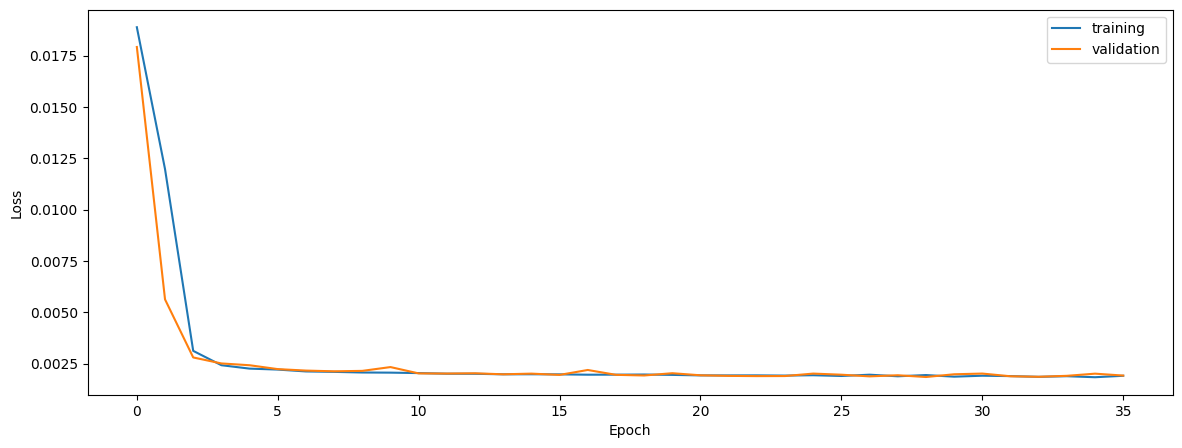

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


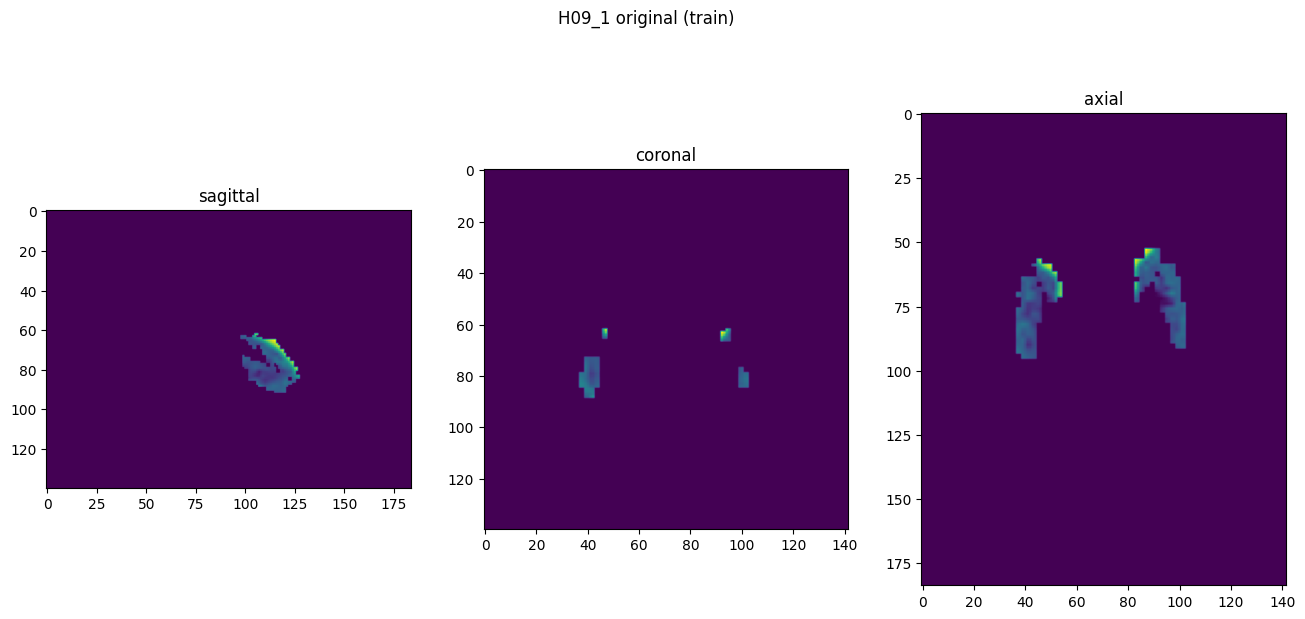

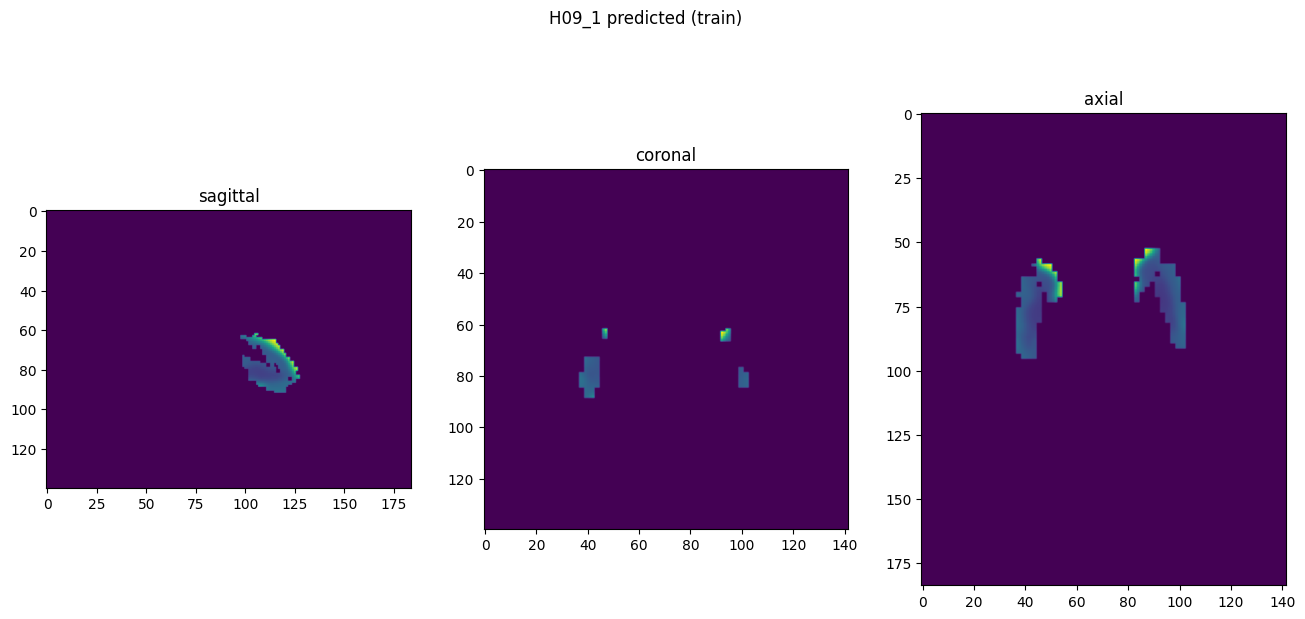

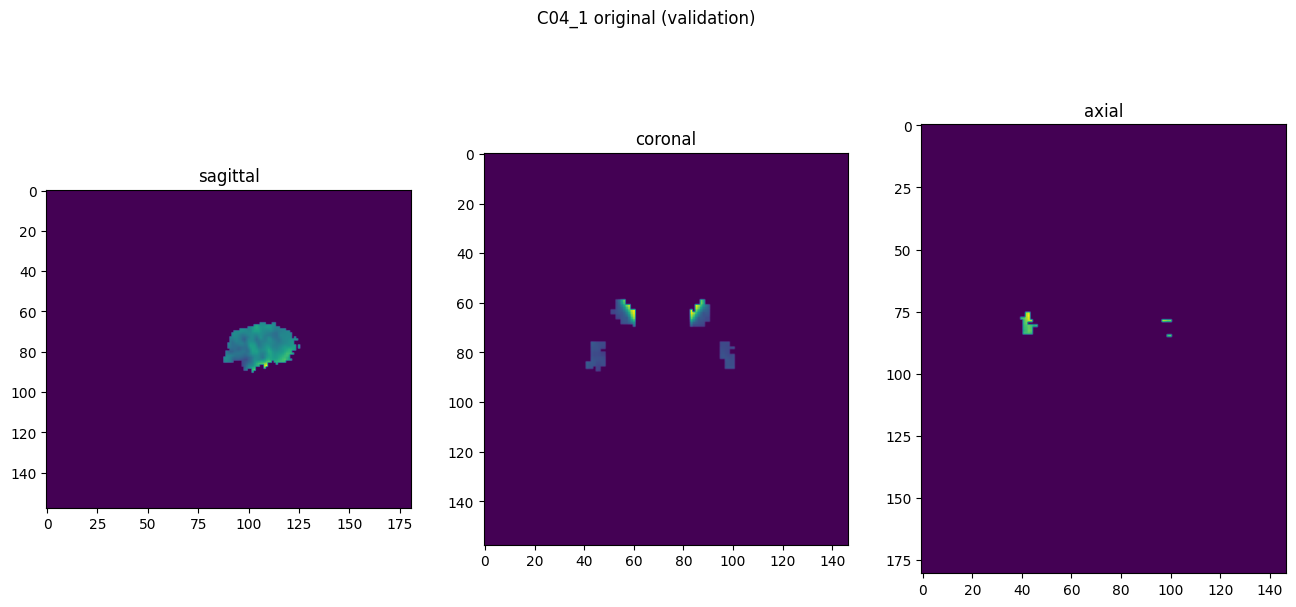

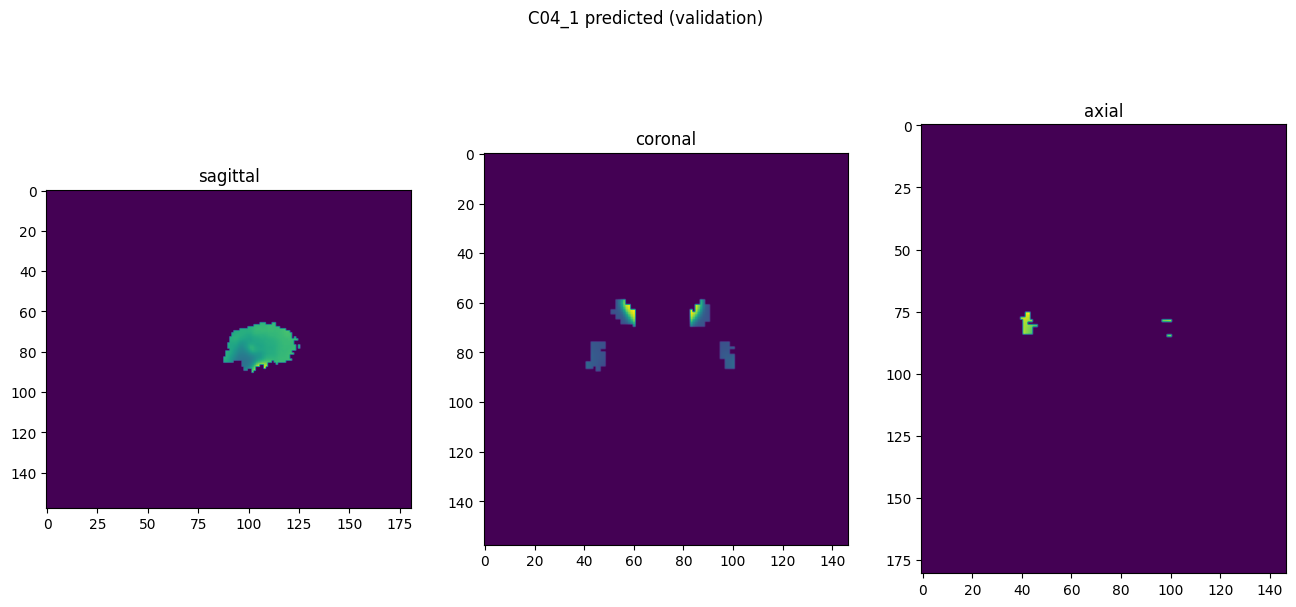

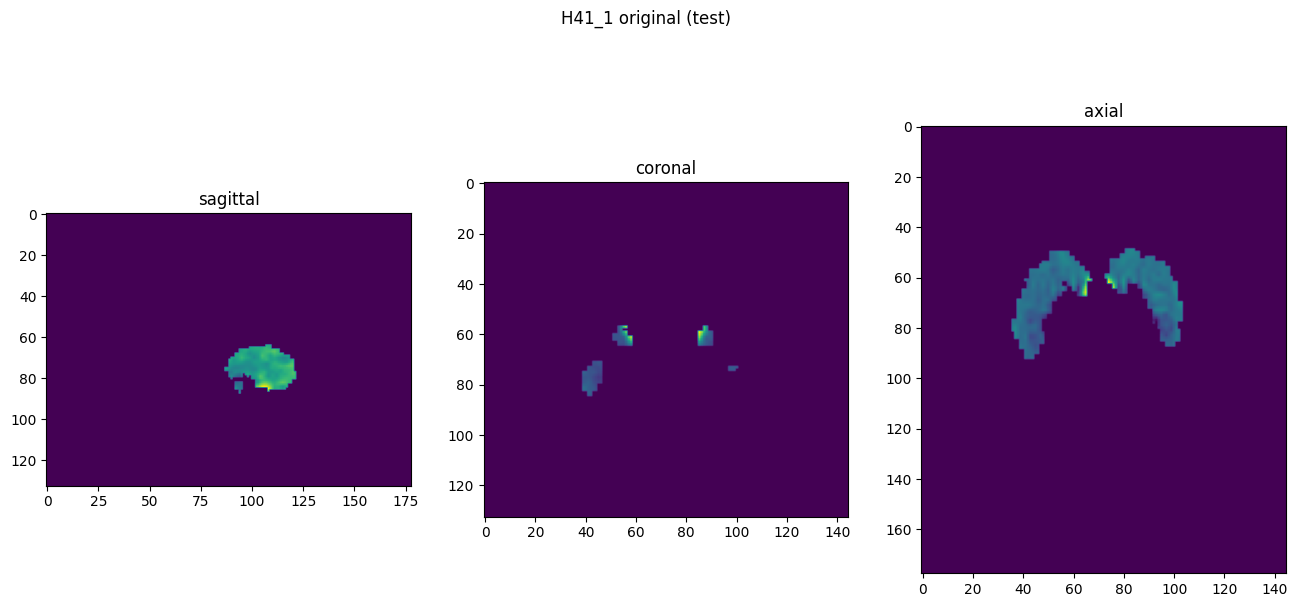

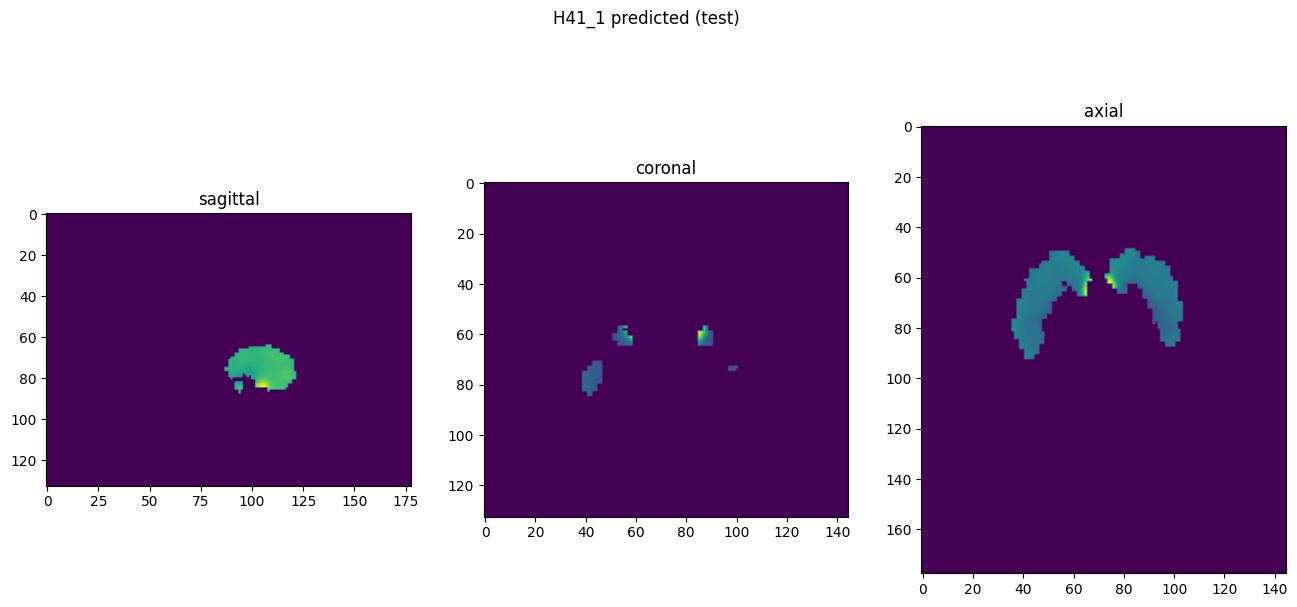

In [10]:
showResults(model, gen, threshold=None, background=False)